# Libraries

In [1]:
import collections
import copy
import itertools
import json
import logging
# Imports and setup
import os
from collections import defaultdict
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, DataLoader
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATv2Conv
from torch_geometric.utils import to_dense_adj, k_hop_subgraph
from tqdm.notebook import tqdm

In [2]:
import warnings
from Bio.PDB.PDBExceptions import PDBConstructionWarning

# Suppress PDB warnings globally
warnings.simplefilter('ignore', PDBConstructionWarning)

from preprocessing_v3 import ProteinAnalyzer, process_pdb_directory
from utils_ln import load_aa_info  # Or define `load_aa_info` in the same script

# Configuration

In [3]:
# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set environment variable for MPS fallback
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

# Set plot style
sns.set_theme()

# Device setup
def get_device():
    """Get the best available device with fallbacks"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        logger.info("MPS (M1/M2) device found but using CPU for some operations due to compatibility")
        return torch.device('cpu')
    return torch.device('cpu')

def compute_average_edges(data_loader):
    """
    Compute the average number of edges and nodes in the dataset
    """
    total_edges = 0
    total_nodes = 0
    num_graphs = 0

    for batch in data_loader:
        total_edges += batch.edge_index.size(1) // 2  # Divide by 2 for undirected edges
        total_nodes += batch.x.size(0)
        num_graphs += 1

    return {
        'avg_edges': total_edges / num_graphs,
        'avg_nodes': total_nodes / num_graphs,
        'avg_backbone': total_nodes / num_graphs - 1  # One less than nodes
    }

# Paths and constants

In [4]:
# Define the file for a demo protein structure
pdb_file = 'data/all_nano_structures_single_domain/1zv5.pdb'

# Define the directory containing the PDB files
pdb_directory = 'data/all_nano_structures_single_domain_clean'

# Define the file containing amino acid information
aa_info_file = 'aa_mass_letter.csv'

# Preprocessed protein dataframes 
output_dir = "processed_dataframes"

# Preprocessing

In [5]:
# Load amino acid information
aa_info = pd.read_csv(aa_info_file)
aa_info['Abbrev.'] = aa_info['Abbrev.'].apply(lambda x: x.upper())
aa_info_dict = aa_info.set_index('Abbrev.').to_dict(orient='index')
#aa_info_dict

In [6]:
# Process PDB directory
dataframes = process_pdb_directory(pdb_directory, aa_info_dict, neighborhood_radius=5.0)


Processing PDBs:   0%|          | 0/1646 [00:00<?, ?it/s]

Processing PDBs: 100%|██████████| 1646/1646 [14:37<00:00,  1.88it/s] 


In [7]:
dataframes[30]

('data/all_nano_structures_single_domain_clean/7f58.pdb',
                X           Y           Z   Avg_Mass  Avg_Neighbor_Dist  \
 0     107.904999  121.867996   64.501999   75.06714           3.793293   
 1     104.841003  121.792000   66.737000  121.15404           4.022797   
 2     102.530998  120.727997   63.889999  181.19124           3.814270   
 3     104.267998  117.370003   63.410000  147.13074           3.804284   
 4     103.281998  114.745003   65.971001  146.14594           4.107006   
 ...          ...         ...         ...        ...                ...   
 1017  135.707001   99.641998  154.020004  119.12034           3.800912   
 1018  134.582993  101.835999  156.908997  146.14594           4.005482   
 1019  135.442993  105.522003  156.419998  117.14784           3.814433   
 1020  134.761993  107.310997  159.716995  119.12034           4.256631   
 1021  135.197998  111.084999  159.800995  117.14784           3.800033   
 
       Max_Neighbor_Dist  Neighbor_Count

In [8]:
import os

# Directory to store processed DataFrames
os.makedirs(output_dir, exist_ok=True)

# Save each DataFrame to a pickle file
for pdb_file, df in dataframes:
    pdb_id = os.path.basename(pdb_file).replace('.pdb', '')  # Extract PDB ID from filename
    df.to_pickle(os.path.join(output_dir, f"{pdb_id}.pkl"))

print(f"DataFrames saved in {output_dir} as pickle files")


DataFrames saved in processed_dataframes as pickle files


# Graph conversion

In [9]:
import numpy as np
import torch
from torch_geometric.data import Data
from sklearn.neighbors import NearestNeighbors

def nanobody_to_graph(df, k=10, include_coordinates=True):
    """
    Convert a nanobody DataFrame into a graph for GTA-based GNNs.

    Parameters:
    - df: DataFrame containing nanobody data.
    - k: Number of nearest neighbors for graph connectivity.
    - include_coordinates: Whether to include 3D coordinates in node features.

    Returns:
    - PyTorch Geometric Data object.
    """
    # Step 1: Node Features
    features_to_include = ['Avg_Mass', 'Avg_Neighbor_Dist', 'Max_Neighbor_Dist', 'Neighbor_Count', 'Small_Molecules_Found']
    node_features = df[features_to_include].values

    # Optionally include coordinates in node features
    if include_coordinates:
        coords = df[['X', 'Y', 'Z']].values
        node_features = np.hstack([node_features, coords])

    # Convert to tensor
    node_features = torch.tensor(node_features, dtype=torch.float)

    # Step 2: KNN-based Edge Construction
    coords = df[['X', 'Y', 'Z']].values
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(coords)
    distances, indices = nbrs.kneighbors(coords)

    edge_index = []
    edge_attr = []
    for i in range(len(indices)):
        for j in range(1, k):  # Skip self-loop (j=0)
            edge_index.append([i, indices[i, j]])
            edge_attr.append([distances[i, j]])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    # Step 3: Create Graph Data Object
    data = Data(
        x=node_features,      # Node features
        edge_index=edge_index,  # Edges
        edge_attr=edge_attr,   # Edge features (distances)
    )
    return data


In [10]:
graphs = []  # Define `graphs` outside the loop
for pdb_file, df in tqdm(dataframes, desc="Processing", unit="graph", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]"):
    graph = nanobody_to_graph(df, k=5, include_coordinates=True)
    graphs.append((pdb_file, graph))


Processing:   0%|          | 0/1646 [00:00<?]

# Graph representation vs reality

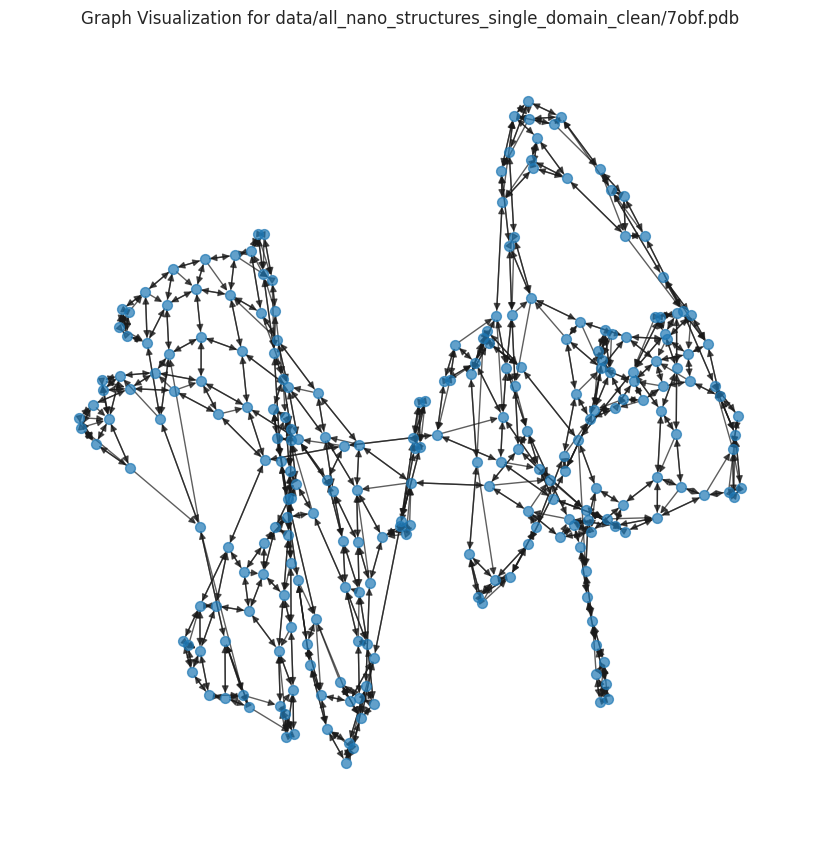

In [11]:
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt

def visualize_nanobody_graph(data, pdb_file):
    """Visualize the nanobody graph."""
    G = to_networkx(data, edge_attrs=['edge_attr'], node_attrs=['x'])
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, with_labels=False, node_size=50, alpha=0.7)
    plt.title(f"Graph Visualization for {pdb_file}")
    plt.show()

# Example
pdb_file, data = graphs[10]
visualize_nanobody_graph(data, pdb_file)


In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

# Define amino acid masses and their corresponding colors
AMINO_ACID_DATA = [
    (89.09404, "Alanine", "blue"),
    (121.15404, "Cysteine", "green"),
    (133.10384, "Aspartic acid", "red"),
    (147.13074, "Glutamic acid", "cyan"),
    (165.19184, "Phenylalanine", "magenta"),
    (75.06714, "Glycine", "yellow"),
    (155.15634, "Histidine", "orange"),
    (131.17464, "Isoleucine/Leucine", "purple"),
    (146.18934, "Lysine", "brown"),
    (149.20784, "Methionine", "pink"),
    (132.11904, "Asparagine", "lime"),
    (255.31000, "Pyrrolysine", "gold"),
    (115.13194, "Proline", "silver"),
    (146.14594, "Glutamine", "teal"),
    (174.20274, "Arginine", "coral"),
    (105.09344, "Serine", "navy"),
    (119.12034, "Threonine", "olive"),
    (168.05300, "Selenocysteine", "maroon"),
    (117.14784, "Valine", "black"),
    (204.22844, "Tryptophan", "violet"),
    (181.19124, "Tyrosine", "gray"),
]

# Convert amino acid data to lookup tables
MASS_TO_COLOR = {mass: color for mass, _, color in AMINO_ACID_DATA}
MASS_TO_NAME = {mass: name for mass, name, _ in AMINO_ACID_DATA}

def map_mass_to_color(mass):
    """Find the closest amino acid mass and return its color."""
    closest_mass = min(MASS_TO_COLOR.keys(), key=lambda m: abs(m - mass))
    return MASS_TO_COLOR[closest_mass]

def visualize_nanobody_graph_aminoacids(data, pdb_file):
    """
    Visualize a nanobody graph with amino acid-specific colors.

    Parameters:
    - data: PyTorch Geometric Data object.
    - pdb_file: Name of the nanobody structure file.
    """
    # Convert to NetworkX graph
    G = to_networkx(data, edge_attrs=['edge_attr'], node_attrs=['x'])

    # Use a layout (try 'spring', 'kamada_kawai', or others)
    pos = nx.spring_layout(G, seed=42)

    # Map nodes to amino acid colors using Avg_Mass (x[0])
    node_colors = [
        map_mass_to_color(node[1]['x'][0]) for node in G.nodes(data=True)
    ]

    # Scale node sizes dynamically (e.g., based on Neighbor_Count, x[3])
    node_sizes = [max(10, node[1]['x'][3] * 50) for node in G.nodes(data=True)]  # Assuming Neighbor_Count is x[3]

    # Scale edge widths dynamically based on edge distances (edge_attr)
    edge_weights = [max(0.1, edge[2]['edge_attr'][0]) for edge in G.edges(data=True)]

    # Create the figure and axes explicitly
    fig, ax = plt.subplots(figsize=(10, 10))

    # Draw the graph
    nx.draw(
        G,
        pos,
        ax=ax,  # Explicitly set the axes for the graph
        with_labels=False,
        node_color=node_colors,
        node_size=node_sizes,
        edge_color='gray',  # Static edge color for better node visibility
        width=edge_weights,
        alpha=0.9  # Transparency for better visibility
    )

    # Add a legend for amino acid colors
    legend_patches = [
        mpl.patches.Patch(color=color, label=name)
        for _, name, color in AMINO_ACID_DATA
    ]
    ax.legend(handles=legend_patches, loc='upper left', fontsize=8, title="Amino Acids")

    # Add a title
    ax.set_title(f"Graph Visualization for {pdb_file}", fontsize=14)
    plt.show()


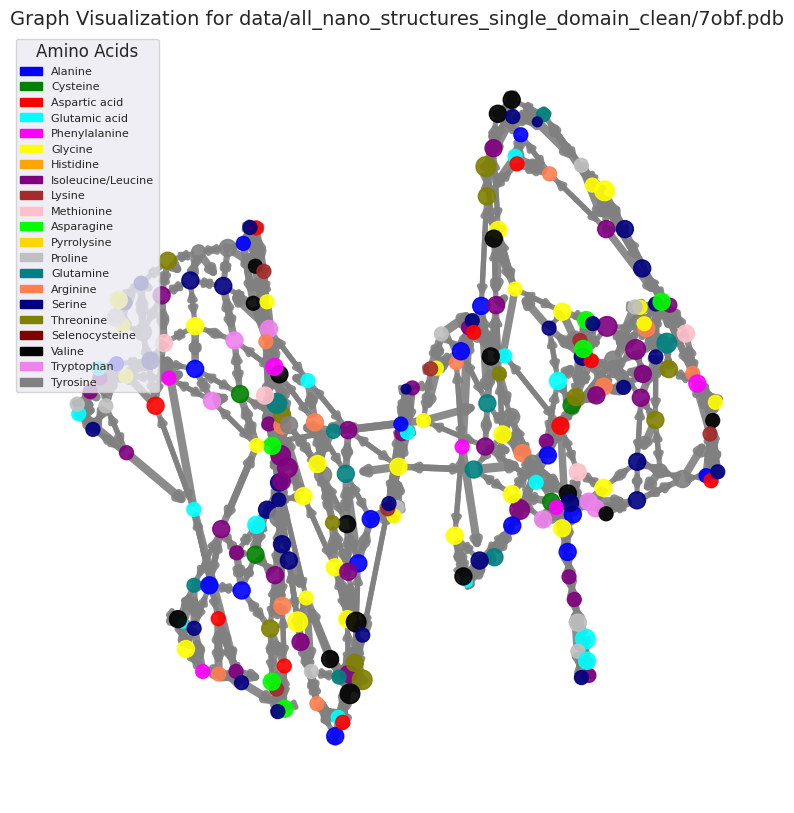

In [13]:
# Example
pdb_file, data = graphs[10]
visualize_nanobody_graph_aminoacids(data, pdb_file)

In [14]:
# from IPython.display import display
# from PIL import Image
# import matplotlib.pyplot as plt

# # Paths to your images
# image_path_1 = "data/mab_dataset/3sn6.png"
# image_path_2 = "data/mab_dataset/3sn6_plot.png"

# # Open the images using PIL
# image_1 = Image.open(image_path_1)
# image_2 = Image.open(image_path_2)

# # Create a matplotlib figure
# fig, axes = plt.subplots(1, 2, figsize=(15, 8))  # 1 row, 2 columns

# # Display the first image
# axes[0].imshow(image_1)
# axes[0].axis('off')  # Hide axes
# axes[0].set_title("Image 1: Original")

# # Display the second image
# axes[1].imshow(image_2)
# axes[1].axis('off')  # Hide axes
# axes[1].set_title("Image 2: Plot")

# # Show the images
# plt.tight_layout()
# plt.show()


# Dataloader

In [15]:
# from torch_geometric.loader import DataLoader
# from sklearn.model_selection import train_test_split

# def split_and_batch_graphs(graphs, batch_size=8, train_ratio=0.8, seed=42):
#     """
#     Split the graphs into train and test datasets, and create DataLoaders for batching.

#     Parameters:
#     - graphs (list): List of `torch_geometric.data.Data` graphs.
#     - batch_size (int): Batch size for the DataLoader.
#     - train_ratio (float): Proportion of data to use for training.
#     - seed (int): Random seed for reproducibility.

#     Returns:
#     - train_loader (DataLoader): DataLoader for the training set.
#     - test_loader (DataLoader): DataLoader for the testing set.
#     """
#     # Set random seed for reproducibility
#     torch.manual_seed(seed)
    
#     # Split into train and test sets
#     train_graphs, test_graphs = train_test_split(graphs, train_size=train_ratio, random_state=seed)
    
#     # Create DataLoaders
#     train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
#     test_loader = DataLoader(test_graphs, batch_size=batch_size, shuffle=False)
    
#     return train_loader, test_loader


In [16]:
# # Unpack graphs
# graph_data = [graph for _, graph in graphs]  # Extract only the `Data` objects

# # Split and batch the graphs
# train_loader, test_loader = split_and_batch_graphs(graph_data, batch_size=16, train_ratio=0.8, seed=42)

# # Optional: Keep file names for reference
# pdb_files = [pdb_file for pdb_file, _ in graphs]

# # Example: Iterate through training batches
# for batch in train_loader:
#     print(batch)  # This should now work as expected


# GTA VAE Alex V10

In [20]:
import torch
from torch_geometric.data import Data, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
import matplotlib.pyplot as plt

def prepare_graphs_for_vae(graph_tuples, batch_size=16, train_ratio=0.8, shuffle=True):
    """
    Prepare PDB graph data for VAE training with normalization
    """
    # Extract PyG Data objects
    graphs = [g[1] for g in graph_tuples]

    # Calculate normalization statistics across all graphs
    all_features = torch.cat([g.x for g in graphs], dim=0)
    feature_means = all_features.mean(dim=0)
    feature_stds = all_features.std(dim=0)

    # Prevent division by zero
    feature_stds = torch.where(feature_stds == 0, torch.ones_like(feature_stds), feature_stds)

    # Normalize all graphs
    for graph in graphs:
        graph.x = (graph.x - feature_means) / feature_stds

        # Also normalize edge attributes (distances)
        if graph.edge_attr is not None:
            edge_mean = graph.edge_attr.mean()
            edge_std = graph.edge_attr.std()
            if edge_std > 0:
                graph.edge_attr = (graph.edge_attr - edge_mean) / edge_std

    # Rest of your existing function...
    train_graphs, test_graphs = train_test_split(
        graphs,
        train_size=train_ratio,
        shuffle=shuffle,
        random_state=42
    )

    train_loader = DataLoader(
        train_graphs,
        batch_size=batch_size,
        shuffle=shuffle
    )

    test_loader = DataLoader(
        test_graphs,
        batch_size=batch_size,
        shuffle=False
    )

    sample_data = train_graphs[0]
    in_channels = sample_data.x.size(1)

    print(f"Dataset prepared:")
    print(f"Number of training graphs: {len(train_graphs)}")
    print(f"Number of test graphs: {len(test_graphs)}")
    print(f"Number of features per node: {in_channels}")
    print(f"Feature means:", feature_means)
    print(f"Feature stds:", feature_stds)

    # Return normalization parameters for later use (e.g., inference)
    return train_loader, test_loader, in_channels, (feature_means, feature_stds)

def setup_and_train_vae(graph_tuples, batch_size=16, hidden_channels=64, latent_channels=32, num_heads=4, num_epochs=100):
    """
    Set up the VAE and start training with attention-based handling of variable-sized graphs
    """
    # Set up device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Prepare data
    train_loader, test_loader, in_channels = prepare_graphs_for_vae(
        graph_tuples,
        batch_size=batch_size
    )

    # Initialize model
    model = ProteinGraphVAE(
        in_channels=in_channels,
        hidden_channels=hidden_channels,
        latent_channels=latent_channels,
        num_heads=num_heads
    ).to(device)

    # Train model
    trained_model, train_losses, test_losses = train_model(
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        device=device,
        num_epochs=num_epochs
    )

    return trained_model, train_losses, test_losses, (train_loader, test_loader)

In [21]:
class ProteinGraphVAE(nn.Module):
    def __init__(self, in_channels, hidden_channels, latent_channels=32, num_heads=4, edge_dim=1):
        super(ProteinGraphVAE, self).__init__()

        # Model parameters
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.latent_channels = latent_channels
        self.edge_dim = edge_dim

        # Feature indices
        self.coord_indices = slice(-3, None)
        self.mass_index = 0
        self.distance_indices = slice(1, 3)
        self.count_index = 3
        self.small_mol_index = 4

        # Loss weights
        # Update these weights in the __init__ method
        self.loss_weights = {
            'mass': 0.1,       # Reduced to prevent domination
            'distance': 0.1,   # Reduced for better balance
            'count': 0.1,      # Reduced for better balance
            'small_mol': 0.1,  # Reduced to prevent instability
            'coord': 0.1,      # Kept small for coordinates
            'edge': 0.1        # Reduced for balance
        }

        # Encoder
        self.encoder_conv1 = torch.nn.ModuleList([
            GATConv(
                in_channels,
                hidden_channels,
                heads=num_heads,
                edge_dim=edge_dim,
                concat=True
            )
        ])

        self.encoder_conv2 = torch.nn.ModuleList([
            GATConv(
                hidden_channels * num_heads,
                hidden_channels,
                edge_dim=edge_dim,
                concat=False
            )
        ])

        # Encoder feedforward
        self.encoder_ff = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_channels * 2, hidden_channels)
        )

        # Latent space
        self.fc_mu = nn.Linear(hidden_channels, latent_channels)
        self.fc_logvar = nn.Linear(hidden_channels, latent_channels)

        # Decoder
        self.shared_decoder = nn.Sequential(
            nn.Linear(latent_channels, hidden_channels * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_channels * 2, hidden_channels * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_channels * 2, hidden_channels)
        )

        # Feature-specific heads
        self.coord_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 3),
            nn.Tanh()  # Constrain coordinates
        )

        self.mass_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 1),
            nn.Softplus()  # Ensure positive mass
        )

        self.distance_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 2),
            nn.Softplus()  # Ensure positive distances
        )

        self.count_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 1),
            nn.Softplus()  # Ensure positive count
        )

        self.small_mol_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 1)  # No activation - using BCEWithLogitsLoss
        )

        # Edge decoder
        self.edge_decoder = nn.Sequential(
            nn.Linear(2 * hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_channels, edge_dim),
            nn.Softplus()  # Ensure positive edge attributes
        )

    def encode(self, x, edge_index, edge_attr, batch):
        # Graph convolutions
        for conv in self.encoder_conv1:
            x = F.relu(conv(x, edge_index, edge_attr=edge_attr))
        x = F.dropout(x, p=0.1, training=self.training)

        for conv in self.encoder_conv2:
            x = F.relu(conv(x, edge_index, edge_attr=edge_attr))
        x = F.dropout(x, p=0.1, training=self.training)

        # Additional feature processing
        x = self.encoder_ff(x)

        # Pool and get latent parameters
        x = global_mean_pool(x, batch)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        return mu

    def decode(self, z, num_nodes, edge_index):
        batch_size = z.size(0)

        # Add position-specific noise
        z = z.unsqueeze(1).expand(-1, num_nodes, -1)
        position_noise = torch.randn_like(z) * 0.05  # Reduced noise
        z = z + position_noise
        z = z.reshape(-1, self.latent_channels)

        # Decode features
        h = self.shared_decoder(z)

        # Decode node features with specific activations
        coords = self.coord_head(h) * 10  # Scale coordinates
        mass = self.mass_head(h)
        distances = self.distance_head(h)
        counts = self.count_head(h)
        small_mols = self.small_mol_head(h)

        # Decode edge attributes
        row, col = edge_index
        edge_features = torch.cat([h[row], h[col]], dim=1)
        decoded_edges = self.edge_decoder(edge_features)

        # Combine features
        features = torch.cat([mass, distances, counts, small_mols, coords], dim=1)
        return features.view(batch_size, num_nodes, -1), decoded_edges

    def feature_specific_loss(self, recon, target, edge_recon, edge_target):
        losses = {}
        EPS = 1e-6
    
        # Mass loss - using softplus for positive values
        mass_pred = F.softplus(recon[..., self.mass_index])  # Remove clamp
        mass_target = target[..., self.mass_index]
        # Use mean instead of max for more stable scaling
        mass_scale = mass_target.abs().mean() + EPS
        mass_pred_scaled = mass_pred / mass_scale
        mass_target_scaled = mass_target / mass_scale
        losses['mass'] = F.mse_loss(mass_pred_scaled, mass_target_scaled) * self.loss_weights['mass']
    
        # Distance loss
        dist_pred = F.softplus(recon[..., self.distance_indices])  # Remove clamp
        dist_target = target[..., self.distance_indices]
        dist_scale = dist_target.abs().mean() + EPS
        dist_pred_scaled = dist_pred / dist_scale
        dist_target_scaled = dist_target / dist_scale
        losses['distance'] = F.mse_loss(dist_pred_scaled, dist_target_scaled) * self.loss_weights['distance']
    
        # Count loss
        count_pred = F.softplus(recon[..., self.count_index])  # Remove clamp
        count_target = target[..., self.count_index]
        count_scale = count_target.abs().mean() + EPS
        count_pred_scaled = count_pred / count_scale
        count_target_scaled = count_target / count_scale
        losses['count'] = F.mse_loss(count_pred_scaled, count_target_scaled) * self.loss_weights['count']
    
        # Small molecules loss - binary cross entropy
        small_mol_pred = recon[..., self.small_mol_index]  # Remove clamp
        small_mol_target = target[..., self.small_mol_index].clamp(0, 1)  # Keep target binary
        losses['small_mol'] = F.binary_cross_entropy_with_logits(
            small_mol_pred,
            small_mol_target,
            reduction='mean'
        ) * self.loss_weights['small_mol']
    
        # Coordinate loss - no activation needed
        coord_pred = recon[..., self.coord_indices]
        coord_target = target[..., self.coord_indices]
        coord_scale = coord_target.abs().mean() + EPS
        coord_pred_scaled = coord_pred / coord_scale
        coord_target_scaled = coord_target / coord_scale
        losses['coord'] = F.mse_loss(coord_pred_scaled, coord_target_scaled) * self.loss_weights['coord']
    
        # Edge loss
        edge_pred = F.softplus(edge_recon)  # Remove clamp
        edge_target_pos = F.softplus(edge_target)
        edge_scale = edge_target_pos.abs().mean() + EPS
        edge_pred_scaled = edge_pred / edge_scale
        edge_target_scaled = edge_target_pos / edge_scale
        losses['edge'] = F.mse_loss(edge_pred_scaled, edge_target_scaled) * self.loss_weights['edge']
    
        # Calculate total loss without clamping
        total_loss = sum(loss for loss in losses.values() if torch.isfinite(loss))
    
        return total_loss, losses

    def forward(self, x, edge_index, edge_attr, batch):
        mu, logvar = self.encode(x, edge_index, edge_attr, batch)
        z = self.reparameterize(mu, logvar)

        unique, counts = torch.unique(batch, return_counts=True)
        max_nodes = counts.max().item()

        recon, edge_recon = self.decode(z, max_nodes, edge_index)
        return recon, edge_recon, mu, logvar

In [22]:
def train_model(model, train_loader, test_loader, device, num_epochs=100, beta=0.01):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    max_grad_norm = 1.0

    print(f"Starting training for {num_epochs} epochs...")
    print(f"Training on device: {device}")
    print(f"Number of training batches: {len(train_loader)}")
    print(f"Number of validation batches: {len(test_loader)}")

    history = {
        'train': {'total_loss': [], 'recon_loss': [], 'kl_loss': [],
                  'mass_loss': [], 'distance_loss': [], 'count_loss': [],
                  'small_mol_loss': [], 'coord_loss': [], 'edge_loss': []},
        'test': {'total_loss': [], 'recon_loss': [], 'kl_loss': [],
                 'mass_loss': [], 'distance_loss': [], 'count_loss': [],
                 'small_mol_loss': [], 'coord_loss': [], 'edge_loss': []}
    }

    from tqdm import tqdm
    import time

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        model.train()
        epoch_losses = {k: 0.0 for k in history['train'].keys()}

        # Progress bar for training
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        batch_count = 0

        for batch in pbar:
            try:
                batch = batch.to(device)
                optimizer.zero_grad()

                # Debug info for first batch
                if batch_count == 0 and epoch == 0:
                    print(f"\nBatch shapes:")
                    print(f"Input x shape: {batch.x.shape}")
                    print(f"Edge index shape: {batch.edge_index.shape}")
                    print(f"Edge attr shape: {batch.edge_attr.shape}")

                # Forward pass
                recon_batch, edge_recon, mu, logvar = model(batch.x, batch.edge_index,
                                                            batch.edge_attr, batch.batch)

                if batch_count == 0 and epoch == 0:
                    print(f"Reconstruction shape: {recon_batch.shape}")
                    print(f"Edge reconstruction shape: {edge_recon.shape}")

                # Reshape original data
                _, counts = torch.unique(batch.batch, return_counts=True)
                max_nodes = counts.max()
                batch_size = len(counts)
                padded_x = torch.zeros(batch_size, max_nodes, batch.x.size(1), device=device)

                start_idx = 0
                for i, count in enumerate(counts):
                    padded_x[i, :count] = batch.x[start_idx:start_idx + count]
                    start_idx += count

                # Calculate losses without clamping
                recon_loss, feature_losses = model.feature_specific_loss(
                    recon_batch, padded_x, edge_recon, batch.edge_attr)

                kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

                # Combine losses without clamping
                loss = recon_loss + beta * kl_loss

                # Detailed diagnostics every 10 batches
                if batch_count % 10 == 0:
                    with torch.no_grad():
                        print("\nDetailed loss diagnostics:")
                        print(f"Raw recon_loss: {recon_loss.item():.4f}")
                        print(f"Raw KL loss: {kl_loss.item():.4f}")
                        print(f"mu mean: {mu.mean().item():.4f}, std: {mu.std().item():.4f}")
                        print(f"logvar mean: {logvar.mean().item():.4f}, std: {logvar.std().item():.4f}")
                        for k, v in feature_losses.items():
                            print(f"{k}: {v.item():.4f}")

                # Backward pass with gradient clipping
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                optimizer.step()

                # Update progress bar and losses
                batch_count += 1
                current_loss = loss.item()
                epoch_losses['total_loss'] += current_loss
                epoch_losses['recon_loss'] += recon_loss.item()
                epoch_losses['kl_loss'] += kl_loss.item()
                for k, v in feature_losses.items():
                    epoch_losses[f'{k}_loss'] += v.item()

                # Update progress bar description
                pbar.set_postfix({
                    'loss': f'{current_loss:.4f}',
                    'recon': f'{recon_loss.item():.4f}',
                    'kl': f'{kl_loss.item():.4f}'
                })

            except Exception as e:
                print(f"\nError in batch {batch_count}:")
                print(str(e))
                print("Batch details:")
                print(f"Batch size: {batch.num_graphs}")
                print(f"Number of nodes: {batch.num_nodes}")
                print(f"Number of edges: {batch.num_edges}")
                continue

        # Average losses
        num_batches = len(train_loader)
        for k in epoch_losses:
            epoch_losses[k] = epoch_losses[k] / num_batches
            history['train'][k].append(epoch_losses[k])

        # Validation phase
        model.eval()
        test_losses = {k: 0.0 for k in history['test'].keys()}

        print("\nStarting validation...")
        with torch.no_grad():
            for batch in tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Valid]'):
                batch = batch.to(device)
                recon_batch, edge_recon, mu, logvar = model(batch.x, batch.edge_index,
                                                            batch.edge_attr, batch.batch)

                # Reshape original data
                _, counts = torch.unique(batch.batch, return_counts=True)
                max_nodes = counts.max()
                batch_size = len(counts)
                padded_x = torch.zeros(batch_size, max_nodes, batch.x.size(1), device=device)

                start_idx = 0
                for i, count in enumerate(counts):
                    padded_x[i, :count] = batch.x[start_idx:start_idx + count]
                    start_idx += count

                recon_loss, feature_losses = model.feature_specific_loss(
                    recon_batch, padded_x, edge_recon, batch.edge_attr)
                kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
                loss = recon_loss + beta * kl_loss

                test_losses['total_loss'] += loss.item()
                test_losses['recon_loss'] += recon_loss.item()
                test_losses['kl_loss'] += kl_loss.item()
                for k, v in feature_losses.items():
                    test_losses[f'{k}_loss'] += v.item()

        # Average test losses
        for k in test_losses:
            test_losses[k] /= len(test_loader)
            history['test'][k].append(test_losses[k])

        epoch_time = time.time() - epoch_start_time

        # Print epoch summary
        print(f'\nEpoch [{epoch+1}/{num_epochs}] - Time: {epoch_time:.2f}s')
        print(f'Train - Total: {epoch_losses["total_loss"]:.4f}, '
              f'Recon: {epoch_losses["recon_loss"]:.4f}, '
              f'KL: {epoch_losses["kl_loss"]:.4f}')
        print('Feature Losses:')
        for k in ['mass_loss', 'distance_loss', 'count_loss',
                  'small_mol_loss', 'coord_loss', 'edge_loss']:
            print(f'  {k}: {epoch_losses[k]:.4f}')

        # Plot training progress
        if (epoch + 1) % 1 == 0:  # Plot every epoch
            if hasattr(plt, 'figure'):
                plt.figure(figsize=(20, 5))

                # Plot 1: Total, Reconstruction, and KL losses
                plt.subplot(1, 3, 1)
                plt.plot(history['train']['total_loss'], label='Total Loss')
                plt.plot(history['train']['recon_loss'], label='Reconstruction Loss')
                plt.plot(history['train']['kl_loss'], label='KL Loss')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.title('Training Losses')
                plt.legend()
                plt.grid(True)

                # Plot 2: Feature-specific losses
                plt.subplot(1, 3, 2)
                for k in ['mass_loss', 'distance_loss', 'count_loss',
                          'small_mol_loss', 'coord_loss', 'edge_loss']:
                    plt.plot(history['train'][k], label=k.replace('_loss', ''))
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.title('Feature-specific Losses')
                plt.legend()
                plt.grid(True)

                # Plot 3: Feature-specific losses (log scale)
                plt.subplot(1, 3, 3)
                for k in ['mass_loss', 'distance_loss', 'count_loss',
                          'small_mol_loss', 'coord_loss', 'edge_loss']:
                    values = [max(1e-10, abs(x)) for x in history['train'][k]]
                    plt.semilogy(values, label=k.replace('_loss', ''))
                plt.xlabel('Epoch')
                plt.ylabel('Loss (log scale)')
                plt.title('Feature-specific Losses (Log Scale)')
                plt.legend()
                plt.grid(True)

                plt.tight_layout()
                plt.show()

    print("\nTraining completed!")
    return model, history


In [23]:
# First, instantiate the model
model = ProteinGraphVAE(
    in_channels=8,
    hidden_channels=64,
    latent_channels=32,
    num_heads=4,
    edge_dim=1
)

# Print model structure and parameter count
print("Model structure:")
print(model)

print("\nParameter count by layer:")
total_params = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.numel()} parameters")
        total_params += param.numel()
print(f"\nTotal trainable parameters: {total_params}")

Model structure:
ProteinGraphVAE(
  (encoder_conv1): ModuleList(
    (0): GATConv(8, 64, heads=4)
  )
  (encoder_conv2): ModuleList(
    (0): GATConv(256, 64, heads=1)
  )
  (encoder_ff): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
  )
  (fc_mu): Linear(in_features=64, out_features=32, bias=True)
  (fc_logvar): Linear(in_features=64, out_features=32, bias=True)
  (shared_decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
  )
  (coord_head): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=3, bias=True

In [30]:
device=get_device()

/home/lara/Documents/CAS_AML/Projects/M3/m3_venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset prepared:
Number of training graphs: 1316
Number of test graphs: 330
Number of features per node: 8
Feature means: tensor([-3.5807e-09, -7.0392e-09,  9.9562e-09,  3.1965e-09, -1.9836e-08,
         1.3890e-08,  1.8456e-08, -3.8034e-09])
Feature stds: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
Starting training for 10 epochs...
Training on device: cpu
Number of training batches: 83
Number of validation batches: 21


Epoch 1/10 [Train]:   0%|          | 0/83 [00:00<?, ?it/s]


Batch shapes:
Input x shape: torch.Size([14288, 8])
Edge index shape: torch.Size([2, 57152])
Edge attr shape: torch.Size([57152, 1])
Reconstruction shape: torch.Size([16, 2761, 8])
Edge reconstruction shape: torch.Size([57152, 1])

Detailed loss diagnostics:
Raw recon_loss: 51.0317
Raw KL loss: 0.0029
mu mean: 0.0007, std: 0.0620
logvar mean: 0.0209, std: 0.0577
mass: 2.3581
distance: 2.0510
count: 45.1773
small_mol: 0.0704
coord: 1.2437
edge: 0.1312


Epoch 1/10 [Train]:  12%|█▏        | 10/83 [00:31<03:23,  2.79s/it, loss=4.7028, recon=4.6975, kl=0.0534]   


Detailed loss diagnostics:
Raw recon_loss: 17.4772
Raw KL loss: 0.0708
mu mean: 0.0057, std: 0.3183
logvar mean: 0.2270, std: 0.1389
mass: 1.0585
distance: 0.8909
count: 14.5110
small_mol: 0.0541
coord: 0.8569
edge: 0.1058


Epoch 1/10 [Train]:  24%|██▍       | 20/83 [00:56<03:08,  2.99s/it, loss=29.4650, recon=29.4513, kl=0.1368]


Detailed loss diagnostics:
Raw recon_loss: 94.8199
Raw KL loss: 0.1270
mu mean: 0.0112, std: 0.4208
logvar mean: 0.3124, std: 0.1757
mass: 5.0982
distance: 3.2959
count: 82.4568
small_mol: 0.0312
coord: 3.8327
edge: 0.1051


Epoch 1/10 [Train]:  36%|███▌      | 30/83 [01:32<02:28,  2.81s/it, loss=15.7965, recon=15.7940, kl=0.0258]


Detailed loss diagnostics:
Raw recon_loss: 43.3375
Raw KL loss: 0.0228
mu mean: 0.0095, std: 0.1800
logvar mean: 0.1269, std: 0.0914
mass: 2.5100
distance: 1.7799
count: 38.0508
small_mol: 0.0274
coord: 0.8626
edge: 0.1068


Epoch 1/10 [Train]:  48%|████▊     | 40/83 [02:02<02:16,  3.17s/it, loss=30.5458, recon=30.5450, kl=0.0084]  


Detailed loss diagnostics:
Raw recon_loss: 29.4882
Raw KL loss: 0.0072
mu mean: 0.0075, std: 0.1005
logvar mean: 0.0532, std: 0.0725
mass: 1.6773
distance: 1.2527
count: 25.0191
small_mol: 0.0151
coord: 1.4173
edge: 0.1066


Epoch 1/10 [Train]:  60%|██████    | 50/83 [02:30<01:44,  3.18s/it, loss=21.3154, recon=21.3149, kl=0.0050]


Detailed loss diagnostics:
Raw recon_loss: 89.3680
Raw KL loss: 0.0041
mu mean: 0.0072, std: 0.0734
logvar mean: -0.0135, std: 0.0745
mass: 4.5223
distance: 3.5462
count: 77.4722
small_mol: 0.0127
coord: 3.7074
edge: 0.1072


Epoch 1/10 [Train]:  72%|███████▏  | 60/83 [03:03<01:13,  3.20s/it, loss=18.1019, recon=18.0984, kl=0.0353]


Detailed loss diagnostics:
Raw recon_loss: 19.9834
Raw KL loss: 0.0256
mu mean: 0.0068, std: 0.1711
logvar mean: -0.1854, std: 0.1195
mass: 1.1950
distance: 0.8141
count: 17.1761
small_mol: 0.0266
coord: 0.6624
edge: 0.1093


Epoch 1/10 [Train]:  84%|████████▍ | 70/83 [03:34<00:43,  3.37s/it, loss=35.8005, recon=35.7804, kl=0.2007]


Detailed loss diagnostics:
Raw recon_loss: 21.3409
Raw KL loss: 0.2600
mu mean: -0.0167, std: 0.5441
logvar mean: -0.6951, std: 0.3917
mass: 1.2926
distance: 0.9829
count: 18.3937
small_mol: 0.0156
coord: 0.5500
edge: 0.1060


Epoch 1/10 [Train]:  96%|█████████▋| 80/83 [04:04<00:07,  2.63s/it, loss=29.4862, recon=29.4728, kl=0.1344]


Detailed loss diagnostics:
Raw recon_loss: 33.0891
Raw KL loss: 0.1645
mu mean: -0.0308, std: 0.4113
logvar mean: -0.5560, std: 0.3558
mass: 1.8942
distance: 1.5077
count: 28.8503
small_mol: 0.0305
coord: 0.7044
edge: 0.1019


Epoch 1/10 [Train]: 100%|██████████| 83/83 [04:10<00:00,  3.02s/it, loss=7.0360, recon=7.0275, kl=0.0852]  



Starting validation...


Epoch 1/10 [Valid]: 100%|██████████| 21/21 [00:18<00:00,  1.16it/s]



Epoch [1/10] - Time: 268.58s
Train - Total: 27.7914, Recon: 27.7836, KL: 0.0778
Feature Losses:
  mass_loss: 1.6187
  distance_loss: 1.2637
  count_loss: 23.7683
  small_mol_loss: 0.0344
  coord_loss: 0.9902
  edge_loss: 0.1084


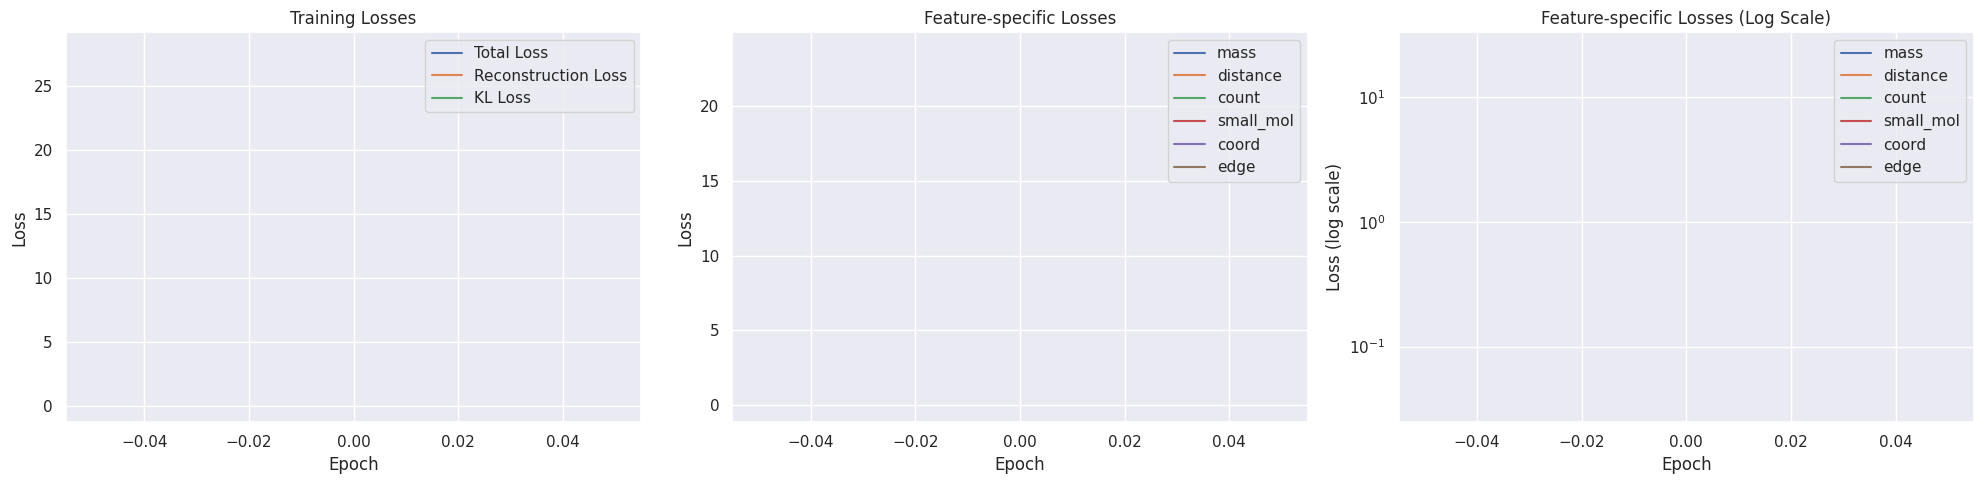

Epoch 2/10 [Train]:   0%|          | 0/83 [00:00<?, ?it/s]


Detailed loss diagnostics:
Raw recon_loss: 23.6555
Raw KL loss: 0.1801
mu mean: -0.0360, std: 0.4348
logvar mean: -0.5777, std: 0.3665
mass: 1.3789
distance: 1.0365
count: 20.4753
small_mol: 0.0220
coord: 0.6392
edge: 0.1036


Epoch 2/10 [Train]:  12%|█▏        | 10/83 [00:30<04:16,  3.51s/it, loss=19.1915, recon=19.1530, kl=0.3849]


Detailed loss diagnostics:
Raw recon_loss: 18.7433
Raw KL loss: 0.3122
mu mean: -0.0375, std: 0.5563
logvar mean: -0.8390, std: 0.5031
mass: 1.1189
distance: 0.8763
count: 16.3172
small_mol: 0.0270
coord: 0.2995
edge: 0.1045


Epoch 2/10 [Train]:  24%|██▍       | 20/83 [01:01<03:14,  3.09s/it, loss=43.5623, recon=43.5543, kl=0.0803]


Detailed loss diagnostics:
Raw recon_loss: 12.9153
Raw KL loss: 0.0840
mu mean: -0.0297, std: 0.2907
logvar mean: -0.4027, std: 0.1882
mass: 0.7937
distance: 0.6158
count: 10.8758
small_mol: 0.0434
coord: 0.4805
edge: 0.1062


Epoch 2/10 [Train]:  36%|███▌      | 30/83 [01:28<02:33,  2.90s/it, loss=14.7350, recon=14.7218, kl=0.1319]  


Detailed loss diagnostics:
Raw recon_loss: 49.8136
Raw KL loss: 0.1606
mu mean: -0.0396, std: 0.4261
logvar mean: -0.5309, std: 0.2612
mass: 2.8095
distance: 1.9638
count: 44.3677
small_mol: 0.0181
coord: 0.5525
edge: 0.1019


Epoch 2/10 [Train]:  48%|████▊     | 40/83 [01:58<01:51,  2.60s/it, loss=15.0786, recon=15.0543, kl=0.2434]


Detailed loss diagnostics:
Raw recon_loss: 13.1284
Raw KL loss: 0.2904
mu mean: -0.0509, std: 0.5446
logvar mean: -0.8172, std: 0.3504
mass: 0.8094
distance: 0.6488
count: 11.2259
small_mol: 0.0344
coord: 0.3072
edge: 0.1027


Epoch 2/10 [Train]:  60%|██████    | 50/83 [02:32<01:54,  3.46s/it, loss=9.2952, recon=9.2817, kl=0.1351]  


Detailed loss diagnostics:
Raw recon_loss: 48.0734
Raw KL loss: 0.1348
mu mean: -0.0304, std: 0.3404
logvar mean: -0.5732, std: 0.2555
mass: 2.5252
distance: 1.9929
count: 42.7820
small_mol: 0.0194
coord: 0.6516
edge: 0.1024


Epoch 2/10 [Train]:  72%|███████▏  | 60/83 [03:04<01:12,  3.14s/it, loss=3.3923, recon=3.3649, kl=0.2736]  


Detailed loss diagnostics:
Raw recon_loss: 19.8095
Raw KL loss: 0.1357
mu mean: -0.0208, std: 0.3610
logvar mean: -0.5577, std: 0.1946
mass: 1.2232
distance: 0.8776
count: 17.2818
small_mol: 0.0301
coord: 0.2927
edge: 0.1041


Epoch 2/10 [Train]:  84%|████████▍ | 70/83 [03:32<00:36,  2.84s/it, loss=32.0057, recon=31.9337, kl=0.7195]


Detailed loss diagnostics:
Raw recon_loss: 52.1840
Raw KL loss: 0.2823
mu mean: -0.0408, std: 0.5791
logvar mean: -0.6647, std: 0.4852
mass: 2.8332
distance: 2.0267
count: 46.4943
small_mol: 0.0226
coord: 0.7048
edge: 0.1024


Epoch 2/10 [Train]:  96%|█████████▋| 80/83 [04:02<00:09,  3.22s/it, loss=53.4347, recon=53.4249, kl=0.0979]


Detailed loss diagnostics:
Raw recon_loss: 31.8730
Raw KL loss: 0.0997
mu mean: -0.0216, std: 0.3362
logvar mean: -0.3805, std: 0.2800
mass: 1.7504
distance: 1.2654
count: 28.3131
small_mol: 0.0199
coord: 0.4210
edge: 0.1031


Epoch 2/10 [Train]: 100%|██████████| 83/83 [04:12<00:00,  3.04s/it, loss=7.1406, recon=7.1338, kl=0.0686]    



Starting validation...


Epoch 2/10 [Valid]: 100%|██████████| 21/21 [00:20<00:00,  1.00it/s]



Epoch [2/10] - Time: 273.45s
Train - Total: 26.4762, Recon: 26.4552, KL: 0.2096
Feature Losses:
  mass_loss: 1.5605
  distance_loss: 1.1932
  count_loss: 23.1128
  small_mol_loss: 0.0310
  coord_loss: 0.4539
  edge_loss: 0.1039


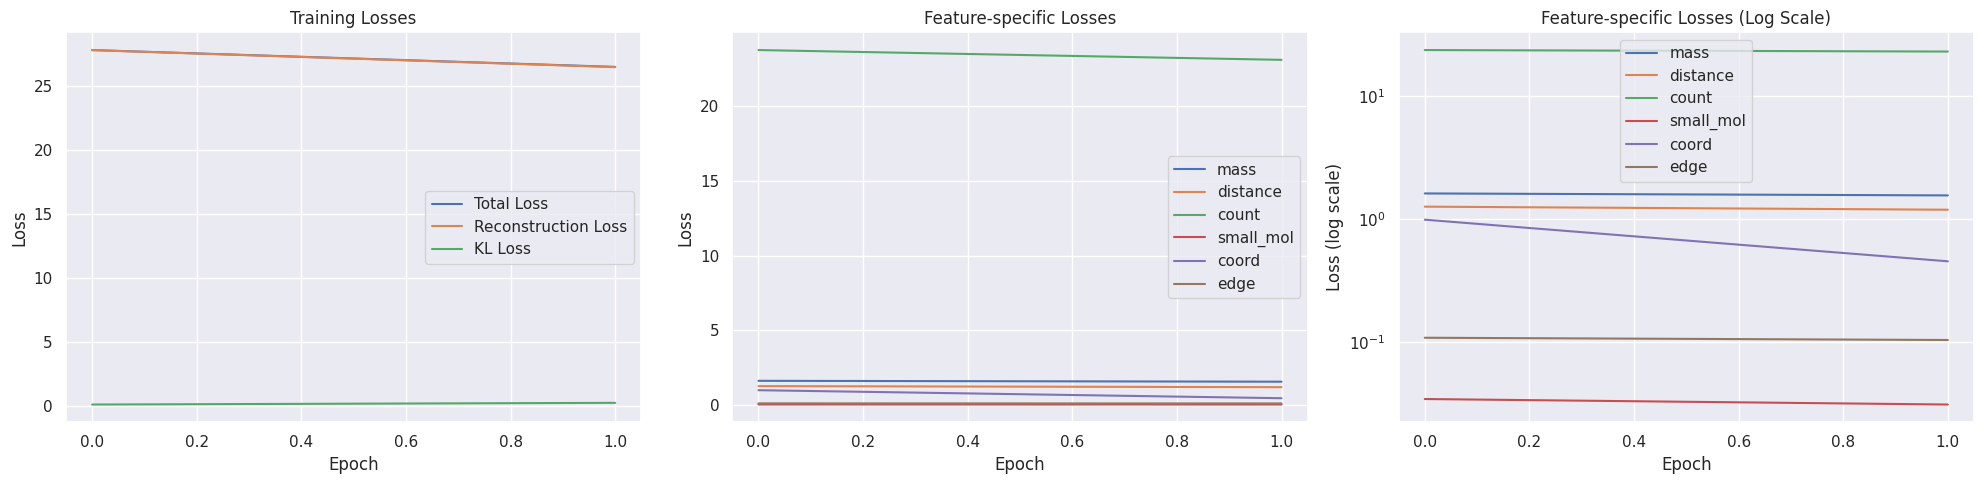

Epoch 3/10 [Train]:   0%|          | 0/83 [00:00<?, ?it/s]


Detailed loss diagnostics:
Raw recon_loss: 15.1563
Raw KL loss: 0.0804
mu mean: -0.0156, std: 0.3024
logvar mean: -0.3707, std: 0.1554
mass: 0.8456
distance: 0.6616
count: 13.1297
small_mol: 0.0473
coord: 0.3676
edge: 0.1045


Epoch 3/10 [Train]:  12%|█▏        | 10/83 [00:34<04:39,  3.83s/it, loss=8.0363, recon=8.0171, kl=0.1920] 


Detailed loss diagnostics:
Raw recon_loss: 4.8988
Raw KL loss: 0.1450
mu mean: -0.0246, std: 0.3847
logvar mean: -0.5468, std: 0.2432
mass: 1.7309
distance: 1.1926
count: 1.3792
small_mol: 0.0312
coord: 0.4575
edge: 0.1074


Epoch 3/10 [Train]:  24%|██▍       | 20/83 [01:17<04:21,  4.15s/it, loss=50.1825, recon=50.1645, kl=0.1802]


Detailed loss diagnostics:
Raw recon_loss: 39.4039
Raw KL loss: 0.1964
mu mean: -0.0188, std: 0.4400
logvar mean: -0.6737, std: 0.2550
mass: 2.2413
distance: 1.7152
count: 34.7609
small_mol: 0.0230
coord: 0.5619
edge: 0.1016


Epoch 3/10 [Train]:  36%|███▌      | 30/83 [01:43<02:19,  2.62s/it, loss=24.2706, recon=24.2589, kl=0.1176]


Detailed loss diagnostics:
Raw recon_loss: 14.4556
Raw KL loss: 0.0812
mu mean: -0.0210, std: 0.2792
logvar mean: -0.4133, std: 0.1719
mass: 0.8701
distance: 0.6869
count: 12.4122
small_mol: 0.0400
coord: 0.3443
edge: 0.1022


Epoch 3/10 [Train]:  48%|████▊     | 40/83 [02:08<01:58,  2.75s/it, loss=11.4508, recon=11.4376, kl=0.1315]


Detailed loss diagnostics:
Raw recon_loss: 95.8988
Raw KL loss: 0.1655
mu mean: -0.0287, std: 0.4446
logvar mean: -0.5006, std: 0.3206
mass: 4.8805
distance: 3.8647
count: 85.6420
small_mol: 0.0132
coord: 1.3952
edge: 0.1032


Epoch 3/10 [Train]:  60%|██████    | 50/83 [02:45<01:58,  3.58s/it, loss=25.3123, recon=25.2742, kl=0.3812]


Detailed loss diagnostics:
Raw recon_loss: 4.1458
Raw KL loss: 0.1090
mu mean: -0.0309, std: 0.3411
logvar mean: -0.4504, std: 0.2117
mass: 1.5170
distance: 1.1053
count: 1.0165
small_mol: 0.0138
coord: 0.3751
edge: 0.1182


Epoch 3/10 [Train]:  72%|███████▏  | 60/83 [03:16<01:21,  3.56s/it, loss=27.8243, recon=27.8133, kl=0.1104]


Detailed loss diagnostics:
Raw recon_loss: 24.3360
Raw KL loss: 0.1391
mu mean: -0.0203, std: 0.3793
logvar mean: -0.5262, std: 0.2501
mass: 1.5864
distance: 1.1237
count: 21.1273
small_mol: 0.0282
coord: 0.3700
edge: 0.1004


Epoch 3/10 [Train]:  84%|████████▍ | 70/83 [03:45<00:30,  2.38s/it, loss=8.4592, recon=8.4475, kl=0.1173]  


Detailed loss diagnostics:
Raw recon_loss: 14.9189
Raw KL loss: 0.2531
mu mean: -0.0235, std: 0.5518
logvar mean: -0.6506, std: 0.3723
mass: 1.0264
distance: 0.7332
count: 12.8869
small_mol: 0.0278
coord: 0.1410
edge: 0.1036


Epoch 3/10 [Train]:  96%|█████████▋| 80/83 [04:22<00:09,  3.27s/it, loss=41.9361, recon=41.9266, kl=0.0954]


Detailed loss diagnostics:
Raw recon_loss: 20.9934
Raw KL loss: 0.0311
mu mean: -0.0158, std: 0.1889
logvar mean: -0.2191, std: 0.0995
mass: 1.2298
distance: 0.9350
count: 18.2839
small_mol: 0.0435
coord: 0.3982
edge: 0.1030


Epoch 3/10 [Train]: 100%|██████████| 83/83 [04:29<00:00,  3.25s/it, loss=5.0640, recon=5.0605, kl=0.0353]  



Starting validation...


Epoch 3/10 [Valid]: 100%|██████████| 21/21 [00:21<00:00,  1.01s/it]



Epoch [3/10] - Time: 290.96s
Train - Total: 25.4636, Recon: 25.4485, KL: 0.1512
Feature Losses:
  mass_loss: 1.5279
  distance_loss: 1.1670
  count_loss: 22.2214
  small_mol_loss: 0.0301
  coord_loss: 0.3983
  edge_loss: 0.1038


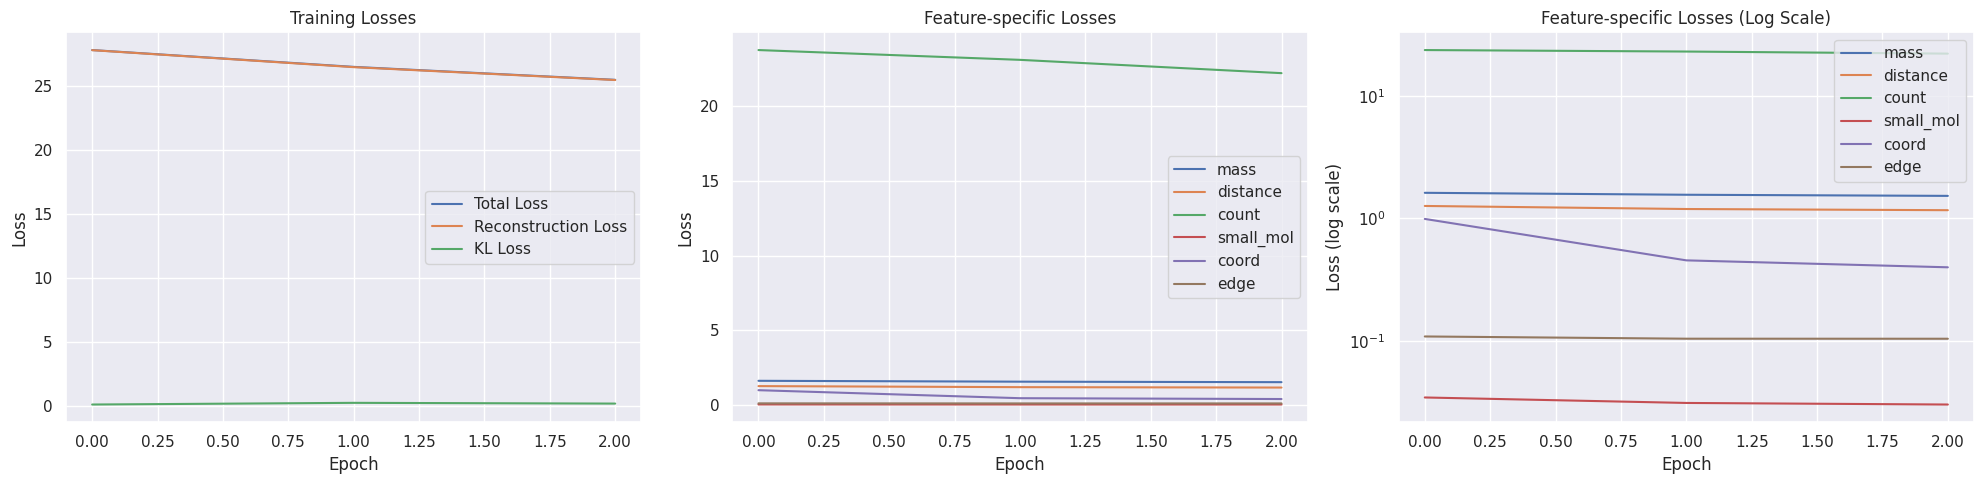

Epoch 4/10 [Train]:   0%|          | 0/83 [00:00<?, ?it/s]


Detailed loss diagnostics:
Raw recon_loss: 12.8483
Raw KL loss: 0.1677
mu mean: -0.0198, std: 0.4764
logvar mean: -0.3685, std: 0.4845
mass: 0.8427
distance: 0.6521
count: 10.9127
small_mol: 0.0413
coord: 0.2976
edge: 0.1019


Epoch 4/10 [Train]:  12%|█▏        | 10/83 [00:29<03:51,  3.17s/it, loss=36.6442, recon=36.6352, kl=0.0907]


Detailed loss diagnostics:
Raw recon_loss: 8.8971
Raw KL loss: 0.0993
mu mean: -0.0301, std: 0.3583
logvar mean: -0.3657, std: 0.1708
mass: 0.5588
distance: 0.4560
count: 7.5592
small_mol: 0.0433
coord: 0.1728
edge: 0.1071


Epoch 4/10 [Train]:  24%|██▍       | 20/83 [00:53<02:41,  2.57s/it, loss=17.8957, recon=17.8855, kl=0.1017]


Detailed loss diagnostics:
Raw recon_loss: 9.1556
Raw KL loss: 0.0709
mu mean: -0.0181, std: 0.2910
logvar mean: -0.3277, std: 0.1591
mass: 0.6162
distance: 0.4901
count: 7.6642
small_mol: 0.0337
coord: 0.2483
edge: 0.1030


Epoch 4/10 [Train]:  36%|███▌      | 30/83 [01:19<02:01,  2.30s/it, loss=8.6104, recon=8.6030, kl=0.0744]  


Detailed loss diagnostics:
Raw recon_loss: 18.2282
Raw KL loss: 0.1646
mu mean: -0.0166, std: 0.4859
logvar mean: -0.3752, std: 0.3588
mass: 1.0730
distance: 0.8898
count: 15.7896
small_mol: 0.0266
coord: 0.3451
edge: 0.1040


Epoch 4/10 [Train]:  48%|████▊     | 40/83 [01:53<02:37,  3.66s/it, loss=44.4662, recon=44.4591, kl=0.0709]


Detailed loss diagnostics:
Raw recon_loss: 18.3283
Raw KL loss: 0.0632
mu mean: -0.0111, std: 0.2757
logvar mean: -0.2945, std: 0.1776
mass: 0.9746
distance: 0.8004
count: 16.0598
small_mol: 0.0650
coord: 0.3235
edge: 0.1050


Epoch 4/10 [Train]:  60%|██████    | 50/83 [02:23<01:40,  3.05s/it, loss=18.4222, recon=18.4164, kl=0.0580]  


Detailed loss diagnostics:
Raw recon_loss: 14.4997
Raw KL loss: 0.0920
mu mean: -0.0113, std: 0.3488
logvar mean: -0.3220, std: 0.2271
mass: 0.9083
distance: 0.7050
count: 12.4513
small_mol: 0.0360
coord: 0.2975
edge: 0.1016


Epoch 4/10 [Train]:  72%|███████▏  | 60/83 [02:51<01:11,  3.13s/it, loss=24.2700, recon=24.2599, kl=0.1008]


Detailed loss diagnostics:
Raw recon_loss: 14.4799
Raw KL loss: 0.0933
mu mean: -0.0154, std: 0.3302
logvar mean: -0.3734, std: 0.2296
mass: 0.8540
distance: 0.6404
count: 12.5374
small_mol: 0.0460
coord: 0.2997
edge: 0.1024


Epoch 4/10 [Train]:  84%|████████▍ | 70/83 [03:23<00:41,  3.16s/it, loss=43.0248, recon=43.0121, kl=0.1269]


Detailed loss diagnostics:
Raw recon_loss: 3.6006
Raw KL loss: 0.1272
mu mean: -0.0152, std: 0.4226
logvar mean: -0.3363, std: 0.2732
mass: 1.2796
distance: 0.9465
count: 0.9773
small_mol: 0.0379
coord: 0.2425
edge: 0.1167


Epoch 4/10 [Train]:  96%|█████████▋| 80/83 [04:00<00:13,  4.63s/it, loss=54.4972, recon=54.4839, kl=0.1339]


Detailed loss diagnostics:
Raw recon_loss: 35.4555
Raw KL loss: 0.0890
mu mean: -0.0073, std: 0.3504
logvar mean: -0.2816, std: 0.2417
mass: 1.8799
distance: 1.5525
count: 31.4392
small_mol: 0.0253
coord: 0.4553
edge: 0.1033


Epoch 4/10 [Train]: 100%|██████████| 83/83 [04:05<00:00,  2.96s/it, loss=14.7182, recon=14.6424, kl=0.7576]



Starting validation...


Epoch 4/10 [Valid]: 100%|██████████| 21/21 [00:20<00:00,  1.02it/s]



Epoch [4/10] - Time: 266.48s
Train - Total: 25.0517, Recon: 25.0394, KL: 0.1236
Feature Losses:
  mass_loss: 1.5085
  distance_loss: 1.1589
  count_loss: 21.8758
  small_mol_loss: 0.0301
  coord_loss: 0.3623
  edge_loss: 0.1038


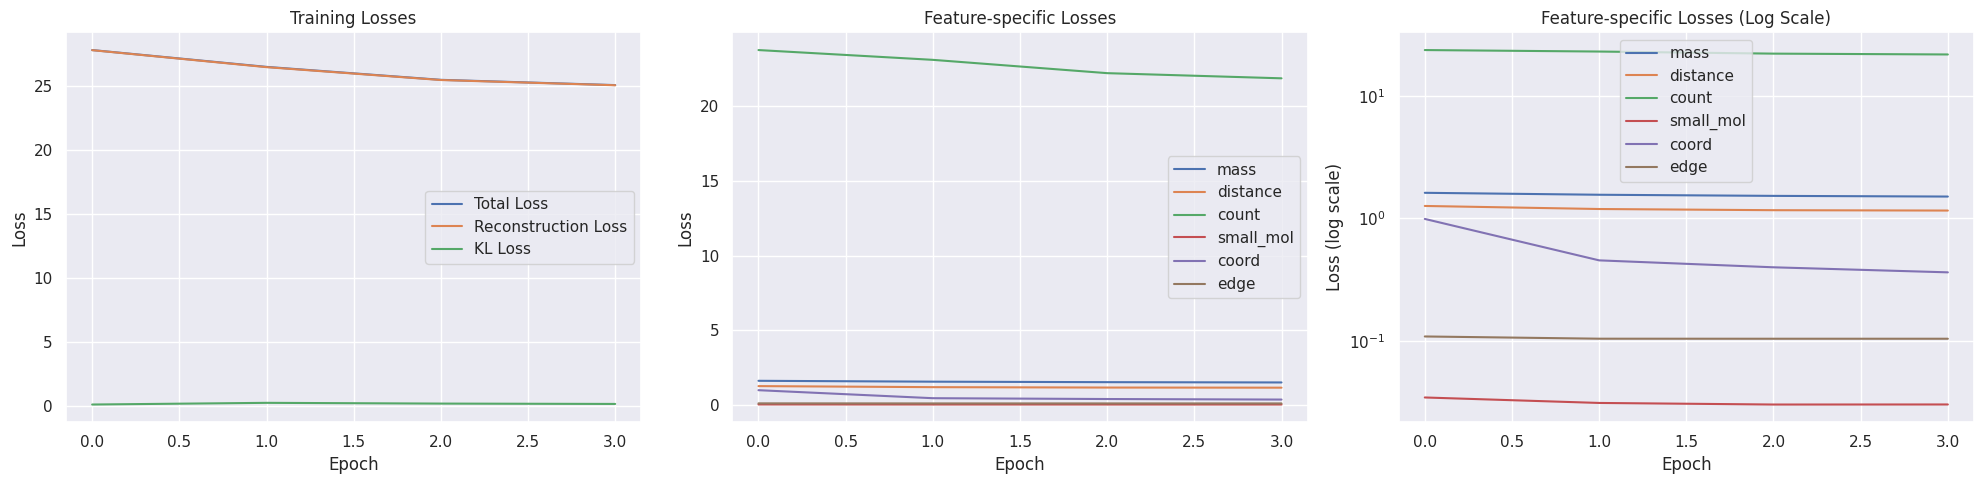

Epoch 5/10 [Train]:   0%|          | 0/83 [00:00<?, ?it/s]


Detailed loss diagnostics:
Raw recon_loss: 22.7853
Raw KL loss: 0.0552
mu mean: -0.0047, std: 0.2616
logvar mean: -0.2526, std: 0.1899
mass: 1.4243
distance: 1.1014
count: 19.8357
small_mol: 0.0374
coord: 0.2855
edge: 0.1010


Epoch 5/10 [Train]:  12%|█▏        | 10/83 [00:28<03:28,  2.85s/it, loss=2.3574, recon=2.3504, kl=0.0703] 


Detailed loss diagnostics:
Raw recon_loss: 22.4745
Raw KL loss: 0.1049
mu mean: -0.0048, std: 0.3855
logvar mean: -0.2872, std: 0.2899
mass: 1.1807
distance: 0.9728
count: 19.7401
small_mol: 0.0307
coord: 0.4471
edge: 0.1032


Epoch 5/10 [Train]:  24%|██▍       | 20/83 [00:53<02:27,  2.35s/it, loss=9.9803, recon=9.9722, kl=0.0811]  


Detailed loss diagnostics:
Raw recon_loss: 72.4090
Raw KL loss: 0.0892
mu mean: -0.0044, std: 0.3418
logvar mean: -0.3060, std: 0.2404
mass: 3.8336
distance: 2.5282
count: 65.3757
small_mol: 0.0373
coord: 0.5344
edge: 0.0997


Epoch 5/10 [Train]:  36%|███▌      | 30/83 [01:29<03:23,  3.84s/it, loss=84.2265, recon=84.2161, kl=0.1040]


Detailed loss diagnostics:
Raw recon_loss: 11.5713
Raw KL loss: 0.0515
mu mean: -0.0057, std: 0.2621
logvar mean: -0.2305, std: 0.1606
mass: 0.6810
distance: 0.5489
count: 9.9781
small_mol: 0.0381
coord: 0.2217
edge: 0.1035


Epoch 5/10 [Train]:  48%|████▊     | 40/83 [01:54<01:32,  2.16s/it, loss=10.2668, recon=10.2624, kl=0.0440]


Detailed loss diagnostics:
Raw recon_loss: 24.3006
Raw KL loss: 0.0759
mu mean: -0.0025, std: 0.3127
logvar mean: -0.2664, std: 0.2693
mass: 1.4925
distance: 1.1878
count: 21.1684
small_mol: 0.0352
coord: 0.3125
edge: 0.1041


Epoch 5/10 [Train]:  60%|██████    | 50/83 [02:27<01:39,  3.00s/it, loss=29.7653, recon=29.7523, kl=0.1300]


Detailed loss diagnostics:
Raw recon_loss: 20.9041
Raw KL loss: 0.1000
mu mean: -0.0056, std: 0.3820
logvar mean: -0.2793, std: 0.2331
mass: 1.3533
distance: 1.0480
count: 18.1031
small_mol: 0.0213
coord: 0.2761
edge: 0.1023


Epoch 5/10 [Train]:  72%|███████▏  | 60/83 [02:56<00:53,  2.31s/it, loss=15.0236, recon=15.0197, kl=0.0389]


Detailed loss diagnostics:
Raw recon_loss: 3.4922
Raw KL loss: 0.0945
mu mean: -0.0061, std: 0.3965
logvar mean: -0.2060, std: 0.1829
mass: 1.3211
distance: 1.0130
count: 0.7282
small_mol: 0.0295
coord: 0.2784
edge: 0.1220


Epoch 5/10 [Train]:  84%|████████▍ | 70/83 [03:25<00:39,  3.02s/it, loss=6.5622, recon=6.5456, kl=0.1654]  


Detailed loss diagnostics:
Raw recon_loss: 45.4472
Raw KL loss: 0.0535
mu mean: -0.0050, std: 0.2634
logvar mean: -0.2324, std: 0.1860
mass: 2.4118
distance: 1.9451
count: 40.5247
small_mol: 0.0217
coord: 0.4431
edge: 0.1007


Epoch 5/10 [Train]:  96%|█████████▋| 80/83 [03:54<00:08,  2.71s/it, loss=14.5693, recon=14.5612, kl=0.0812]


Detailed loss diagnostics:
Raw recon_loss: 8.4163
Raw KL loss: 0.0872
mu mean: -0.0020, std: 0.3476
logvar mean: -0.2597, std: 0.2567
mass: 0.5697
distance: 0.4288
count: 7.0687
small_mol: 0.0682
coord: 0.1795
edge: 0.1015


Epoch 5/10 [Train]: 100%|██████████| 83/83 [03:58<00:00,  2.88s/it, loss=7.7693, recon=7.7522, kl=0.1705]  



Starting validation...


Epoch 5/10 [Valid]: 100%|██████████| 21/21 [00:25<00:00,  1.21s/it]



Epoch [5/10] - Time: 264.23s
Train - Total: 25.9859, Recon: 25.9763, KL: 0.0956
Feature Losses:
  mass_loss: 1.5481
  distance_loss: 1.1810
  count_loss: 22.7720
  small_mol_loss: 0.0293
  coord_loss: 0.3418
  edge_loss: 0.1042


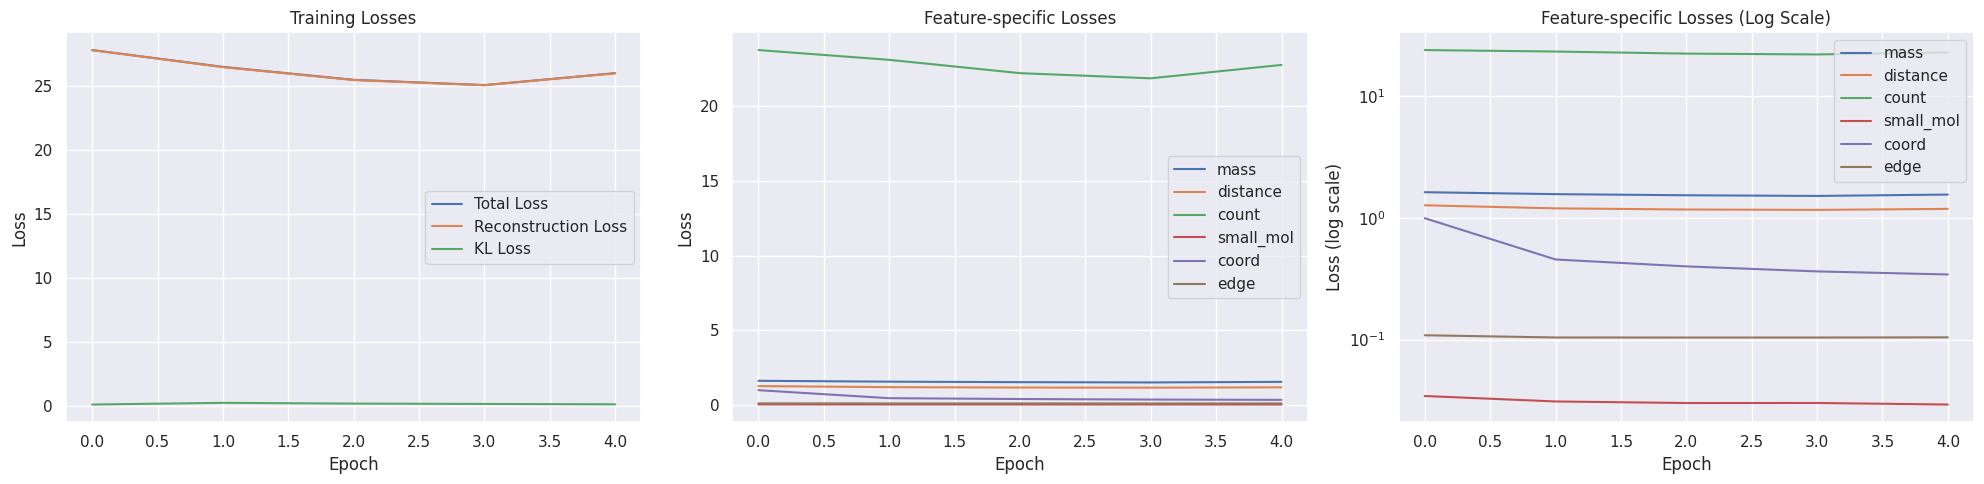

Epoch 6/10 [Train]:   0%|          | 0/83 [00:00<?, ?it/s]


Detailed loss diagnostics:
Raw recon_loss: 80.0126
Raw KL loss: 0.1504
mu mean: -0.0084, std: 0.4835
logvar mean: -0.2455, std: 0.3569
mass: 4.0716
distance: 3.1575
count: 71.2766
small_mol: 0.0106
coord: 1.3932
edge: 0.1032


Epoch 6/10 [Train]:  12%|█▏        | 10/83 [00:39<04:19,  3.55s/it, loss=4.7275, recon=4.7061, kl=0.2137] 


Detailed loss diagnostics:
Raw recon_loss: 11.6407
Raw KL loss: 0.0441
mu mean: -0.0010, std: 0.2391
logvar mean: -0.2029, std: 0.1759
mass: 0.7169
distance: 0.5969
count: 9.9149
small_mol: 0.0731
coord: 0.2371
edge: 0.1017


Epoch 6/10 [Train]:  24%|██▍       | 20/83 [01:09<03:30,  3.34s/it, loss=19.7114, recon=19.6762, kl=0.3521]


Detailed loss diagnostics:
Raw recon_loss: 39.6156
Raw KL loss: 0.0636
mu mean: -0.0098, std: 0.3017
logvar mean: -0.2044, std: 0.2178
mass: 2.1324
distance: 1.7084
count: 35.2010
small_mol: 0.0388
coord: 0.4324
edge: 0.1027


Epoch 6/10 [Train]:  36%|███▌      | 30/83 [01:37<02:20,  2.65s/it, loss=3.4770, recon=3.4660, kl=0.1097]  


Detailed loss diagnostics:
Raw recon_loss: 13.8013
Raw KL loss: 0.0556
mu mean: -0.0057, std: 0.2797
logvar mean: -0.2089, std: 0.1871
mass: 0.8819
distance: 0.6966
count: 11.8001
small_mol: 0.0399
coord: 0.2815
edge: 0.1014


Epoch 6/10 [Train]:  48%|████▊     | 40/83 [02:07<02:16,  3.16s/it, loss=27.1381, recon=27.1312, kl=0.0689]


Detailed loss diagnostics:
Raw recon_loss: 55.2775
Raw KL loss: 0.1158
mu mean: -0.0198, std: 0.4411
logvar mean: -0.1955, std: 0.2228
mass: 2.6932
distance: 2.2309
count: 49.7565
small_mol: 0.0212
coord: 0.4700
edge: 0.1057


Epoch 6/10 [Train]:  60%|██████    | 50/83 [02:36<01:34,  2.87s/it, loss=34.7193, recon=34.7127, kl=0.0655]


Detailed loss diagnostics:
Raw recon_loss: 22.8665
Raw KL loss: 0.0573
mu mean: -0.0195, std: 0.3063
logvar mean: -0.1489, std: 0.1540
mass: 1.4457
distance: 1.0683
count: 19.8355
small_mol: 0.0136
coord: 0.4017
edge: 0.1016


Epoch 6/10 [Train]:  72%|███████▏  | 60/83 [03:05<01:00,  2.63s/it, loss=23.1170, recon=23.1119, kl=0.0509]


Detailed loss diagnostics:
Raw recon_loss: 11.9088
Raw KL loss: 0.0919
mu mean: -0.0077, std: 0.3552
logvar mean: -0.2688, std: 0.2803
mass: 0.8260
distance: 0.6168
count: 10.1988
small_mol: 0.0254
coord: 0.1407
edge: 0.1012


Epoch 6/10 [Train]:  84%|████████▍ | 70/83 [03:34<00:39,  3.01s/it, loss=26.8562, recon=26.8481, kl=0.0804]


Detailed loss diagnostics:
Raw recon_loss: 41.8875
Raw KL loss: 0.0781
mu mean: -0.0185, std: 0.3229
logvar mean: -0.2569, std: 0.2539
mass: 2.3492
distance: 1.9638
count: 37.1337
small_mol: 0.0241
coord: 0.3131
edge: 0.1036


Epoch 6/10 [Train]:  96%|█████████▋| 80/83 [04:00<00:08,  2.86s/it, loss=18.6890, recon=18.6807, kl=0.0835]


Detailed loss diagnostics:
Raw recon_loss: 31.4856
Raw KL loss: 0.1333
mu mean: -0.0181, std: 0.4357
logvar mean: -0.2992, std: 0.3692
mass: 1.7600
distance: 1.3512
count: 27.7889
small_mol: 0.0225
coord: 0.4605
edge: 0.1026


Epoch 6/10 [Train]: 100%|██████████| 83/83 [04:06<00:00,  2.97s/it, loss=8.6510, recon=8.6478, kl=0.0319]  



Starting validation...


Epoch 6/10 [Valid]: 100%|██████████| 21/21 [00:18<00:00,  1.13it/s]



Epoch [6/10] - Time: 264.91s
Train - Total: 25.1372, Recon: 25.1274, KL: 0.0979
Feature Losses:
  mass_loss: 1.5187
  distance_loss: 1.1622
  count_loss: 21.9712
  small_mol_loss: 0.0311
  coord_loss: 0.3404
  edge_loss: 0.1037


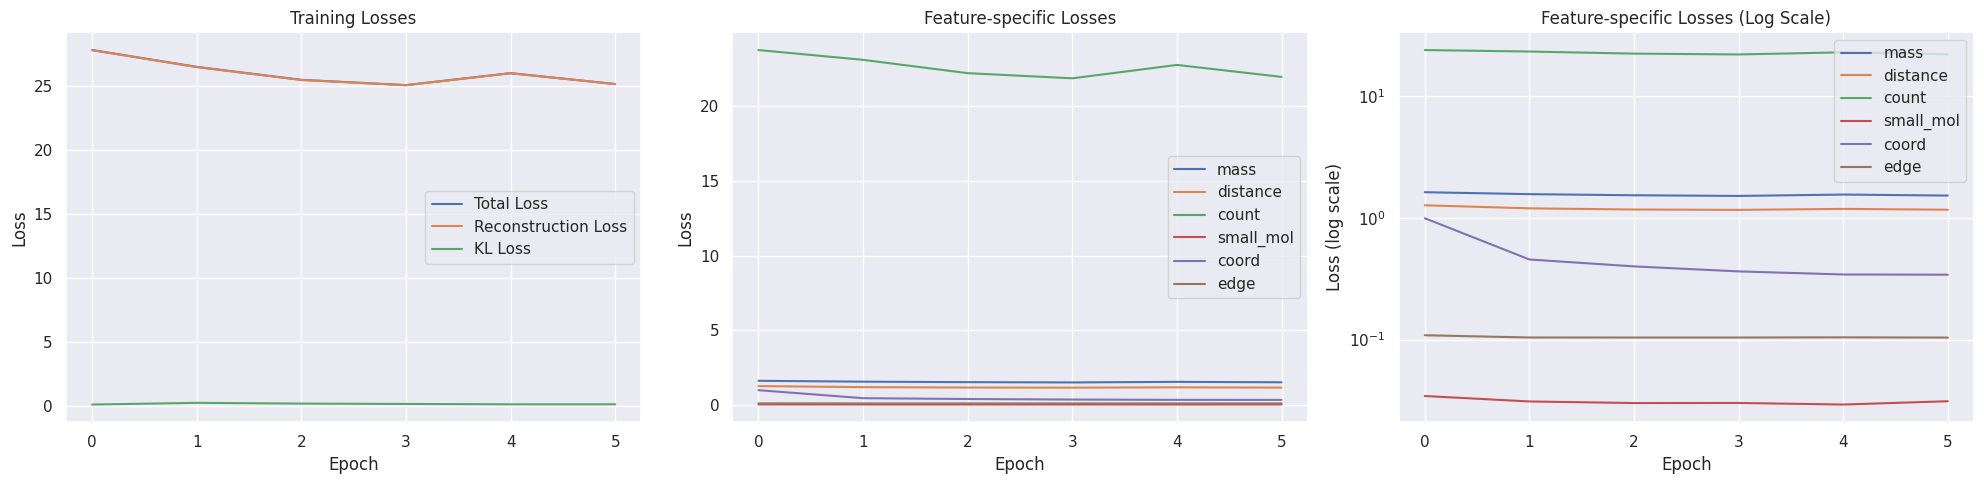

Epoch 7/10 [Train]:   0%|          | 0/83 [00:00<?, ?it/s]


Detailed loss diagnostics:
Raw recon_loss: 20.9394
Raw KL loss: 0.0839
mu mean: -0.0216, std: 0.3402
logvar mean: -0.2531, std: 0.2601
mass: 1.2328
distance: 0.9207
count: 18.3484
small_mol: 0.0407
coord: 0.2921
edge: 0.1047


Epoch 7/10 [Train]:  12%|█▏        | 10/83 [00:28<03:33,  2.93s/it, loss=19.2489, recon=19.2434, kl=0.0555]


Detailed loss diagnostics:
Raw recon_loss: 2.1854
Raw KL loss: 0.1431
mu mean: -0.0249, std: 0.4919
logvar mean: -0.2131, std: 0.2484
mass: 0.6512
distance: 0.5228
count: 0.6889
small_mol: 0.0366
coord: 0.1744
edge: 0.1115


Epoch 7/10 [Train]:  24%|██▍       | 20/83 [00:56<02:57,  2.81s/it, loss=23.6227, recon=23.6018, kl=0.2090]


Detailed loss diagnostics:
Raw recon_loss: 89.0059
Raw KL loss: 0.0957
mu mean: -0.0127, std: 0.3934
logvar mean: -0.2156, std: 0.2044
mass: 4.0393
distance: 3.6159
count: 80.6651
small_mol: 0.0225
coord: 0.5601
edge: 0.1031


Epoch 7/10 [Train]:  36%|███▌      | 30/83 [01:29<02:59,  3.39s/it, loss=109.1268, recon=109.1204, kl=0.0639]


Detailed loss diagnostics:
Raw recon_loss: 35.5057
Raw KL loss: 0.0862
mu mean: -0.0095, std: 0.3532
logvar mean: -0.2353, std: 0.2666
mass: 1.9187
distance: 1.5493
count: 31.6178
small_mol: 0.0218
coord: 0.2925
edge: 0.1056


Epoch 7/10 [Train]:  48%|████▊     | 40/83 [01:59<02:17,  3.19s/it, loss=13.2940, recon=13.2885, kl=0.0553]  


Detailed loss diagnostics:
Raw recon_loss: 27.8885
Raw KL loss: 0.0571
mu mean: -0.0055, std: 0.2858
logvar mean: -0.1936, std: 0.2057
mass: 1.5361
distance: 1.2308
count: 24.6540
small_mol: 0.0275
coord: 0.3360
edge: 0.1042


Epoch 7/10 [Train]:  60%|██████    | 50/83 [02:23<01:14,  2.25s/it, loss=8.7711, recon=8.7674, kl=0.0365]  


Detailed loss diagnostics:
Raw recon_loss: 11.9966
Raw KL loss: 0.0595
mu mean: -0.0129, std: 0.2748
logvar mean: -0.2297, std: 0.2369
mass: 0.7741
distance: 0.5739
count: 10.2908
small_mol: 0.0353
coord: 0.2210
edge: 0.1015


Epoch 7/10 [Train]:  72%|███████▏  | 60/83 [02:47<00:55,  2.43s/it, loss=3.0165, recon=3.0085, kl=0.0792]  


Detailed loss diagnostics:
Raw recon_loss: 22.8026
Raw KL loss: 0.0342
mu mean: -0.0060, std: 0.1929
logvar mean: -0.1892, std: 0.1986
mass: 1.3088
distance: 1.0238
count: 19.9775
small_mol: 0.0331
coord: 0.3555
edge: 0.1039


Epoch 7/10 [Train]:  84%|████████▍ | 70/83 [03:23<00:43,  3.35s/it, loss=18.9822, recon=18.9724, kl=0.0985]


Detailed loss diagnostics:
Raw recon_loss: 19.3396
Raw KL loss: 0.1568
mu mean: -0.0239, std: 0.4658
logvar mean: -0.2928, std: 0.4834
mass: 1.2101
distance: 0.9696
count: 16.8120
small_mol: 0.0269
coord: 0.2186
edge: 0.1025


Epoch 7/10 [Train]:  96%|█████████▋| 80/83 [03:49<00:07,  2.52s/it, loss=31.3712, recon=31.3545, kl=0.1670]


Detailed loss diagnostics:
Raw recon_loss: 38.2952
Raw KL loss: 0.2488
mu mean: -0.0283, std: 0.6152
logvar mean: -0.3098, std: 0.5915
mass: 2.2824
distance: 1.6707
count: 33.9543
small_mol: 0.0212
coord: 0.2650
edge: 0.1016


Epoch 7/10 [Train]: 100%|██████████| 83/83 [03:55<00:00,  2.84s/it, loss=12.1786, recon=12.1754, kl=0.0320]



Starting validation...


Epoch 7/10 [Valid]: 100%|██████████| 21/21 [00:18<00:00,  1.13it/s]



Epoch [7/10] - Time: 254.09s
Train - Total: 27.6418, Recon: 27.6322, KL: 0.0967
Feature Losses:
  mass_loss: 1.6167
  distance_loss: 1.2368
  count_loss: 24.3049
  small_mol_loss: 0.0299
  coord_loss: 0.3402
  edge_loss: 0.1036


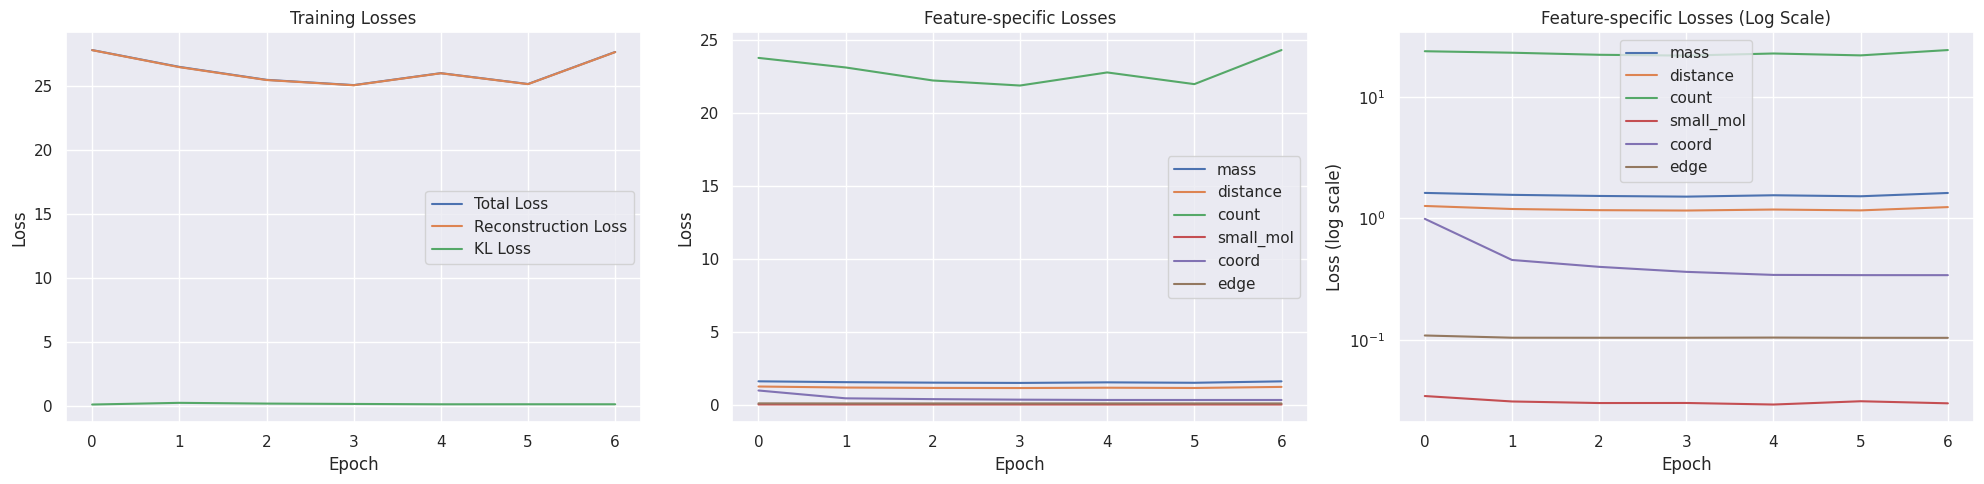

Epoch 8/10 [Train]:   0%|          | 0/83 [00:00<?, ?it/s]


Detailed loss diagnostics:
Raw recon_loss: 27.7199
Raw KL loss: 0.0922
mu mean: -0.0124, std: 0.3495
logvar mean: -0.2530, std: 0.3221
mass: 1.5953
distance: 1.2547
count: 24.2310
small_mol: 0.0416
coord: 0.4948
edge: 0.1026


Epoch 8/10 [Train]:  12%|█▏        | 10/83 [00:26<03:10,  2.60s/it, loss=30.5630, recon=30.5524, kl=0.1064]


Detailed loss diagnostics:
Raw recon_loss: 28.9392
Raw KL loss: 0.1302
mu mean: -0.0142, std: 0.4387
logvar mean: -0.2466, std: 0.3762
mass: 1.7855
distance: 1.3357
count: 25.4205
small_mol: 0.0282
coord: 0.2658
edge: 0.1034


Epoch 8/10 [Train]:  24%|██▍       | 20/83 [00:59<03:08,  2.99s/it, loss=21.6089, recon=21.5908, kl=0.1806]


Detailed loss diagnostics:
Raw recon_loss: 35.4605
Raw KL loss: 0.1183
mu mean: 0.0086, std: 0.4413
logvar mean: -0.1875, std: 0.2668
mass: 1.9540
distance: 1.6053
count: 31.4330
small_mol: 0.0123
coord: 0.3528
edge: 0.1032


Epoch 8/10 [Train]:  36%|███▌      | 30/83 [01:27<02:34,  2.91s/it, loss=48.2436, recon=48.2345, kl=0.0916]


Detailed loss diagnostics:
Raw recon_loss: 16.7972
Raw KL loss: 0.1035
mu mean: -0.0040, std: 0.3953
logvar mean: -0.2169, std: 0.3090
mass: 1.0815
distance: 0.8292
count: 14.4142
small_mol: 0.0138
coord: 0.3565
edge: 0.1021


Epoch 8/10 [Train]:  48%|████▊     | 40/83 [01:54<01:52,  2.61s/it, loss=25.3664, recon=25.3615, kl=0.0488]


Detailed loss diagnostics:
Raw recon_loss: 8.1363
Raw KL loss: 0.0484
mu mean: 0.0063, std: 0.2571
logvar mean: -0.1795, std: 0.2079
mass: 0.6015
distance: 0.4181
count: 6.7753
small_mol: 0.0437
coord: 0.1937
edge: 0.1040


Epoch 8/10 [Train]:  60%|██████    | 50/83 [02:25<01:42,  3.10s/it, loss=24.1344, recon=24.1289, kl=0.0550]


Detailed loss diagnostics:
Raw recon_loss: 12.4638
Raw KL loss: 0.0572
mu mean: -0.0160, std: 0.2662
logvar mean: -0.2275, std: 0.2420
mass: 0.8306
distance: 0.6339
count: 10.6118
small_mol: 0.0626
coord: 0.2234
edge: 0.1014


Epoch 8/10 [Train]:  72%|███████▏  | 60/83 [02:56<01:27,  3.79s/it, loss=43.0172, recon=42.9981, kl=0.1917]


Detailed loss diagnostics:
Raw recon_loss: 15.2811
Raw KL loss: 0.0918
mu mean: -0.0141, std: 0.3584
logvar mean: -0.2377, std: 0.3065
mass: 0.9654
distance: 0.8106
count: 13.1356
small_mol: 0.0256
coord: 0.2412
edge: 0.1027


Epoch 8/10 [Train]:  84%|████████▍ | 70/83 [03:21<00:32,  2.52s/it, loss=24.8474, recon=24.8381, kl=0.0935]


Detailed loss diagnostics:
Raw recon_loss: 2.9689
Raw KL loss: 0.0999
mu mean: 0.0005, std: 0.3924
logvar mean: -0.2076, std: 0.2764
mass: 1.0744
distance: 0.7485
count: 0.7121
small_mol: 0.0350
coord: 0.2822
edge: 0.1168


Epoch 8/10 [Train]:  96%|█████████▋| 80/83 [03:50<00:09,  3.23s/it, loss=10.5487, recon=10.5459, kl=0.0280]


Detailed loss diagnostics:
Raw recon_loss: 15.4356
Raw KL loss: 0.0695
mu mean: -0.0189, std: 0.2990
logvar mean: -0.2306, std: 0.2805
mass: 0.9808
distance: 0.7282
count: 13.3848
small_mol: 0.0360
coord: 0.2037
edge: 0.1022


Epoch 8/10 [Train]: 100%|██████████| 83/83 [03:57<00:00,  2.86s/it, loss=14.4305, recon=14.4283, kl=0.0226]



Starting validation...


Epoch 8/10 [Valid]: 100%|██████████| 21/21 [00:18<00:00,  1.12it/s]



Epoch [8/10] - Time: 256.41s
Train - Total: 25.1836, Recon: 25.1724, KL: 0.1119
Feature Losses:
  mass_loss: 1.5634
  distance_loss: 1.1843
  count_loss: 21.9639
  small_mol_loss: 0.0293
  coord_loss: 0.3279
  edge_loss: 0.1036


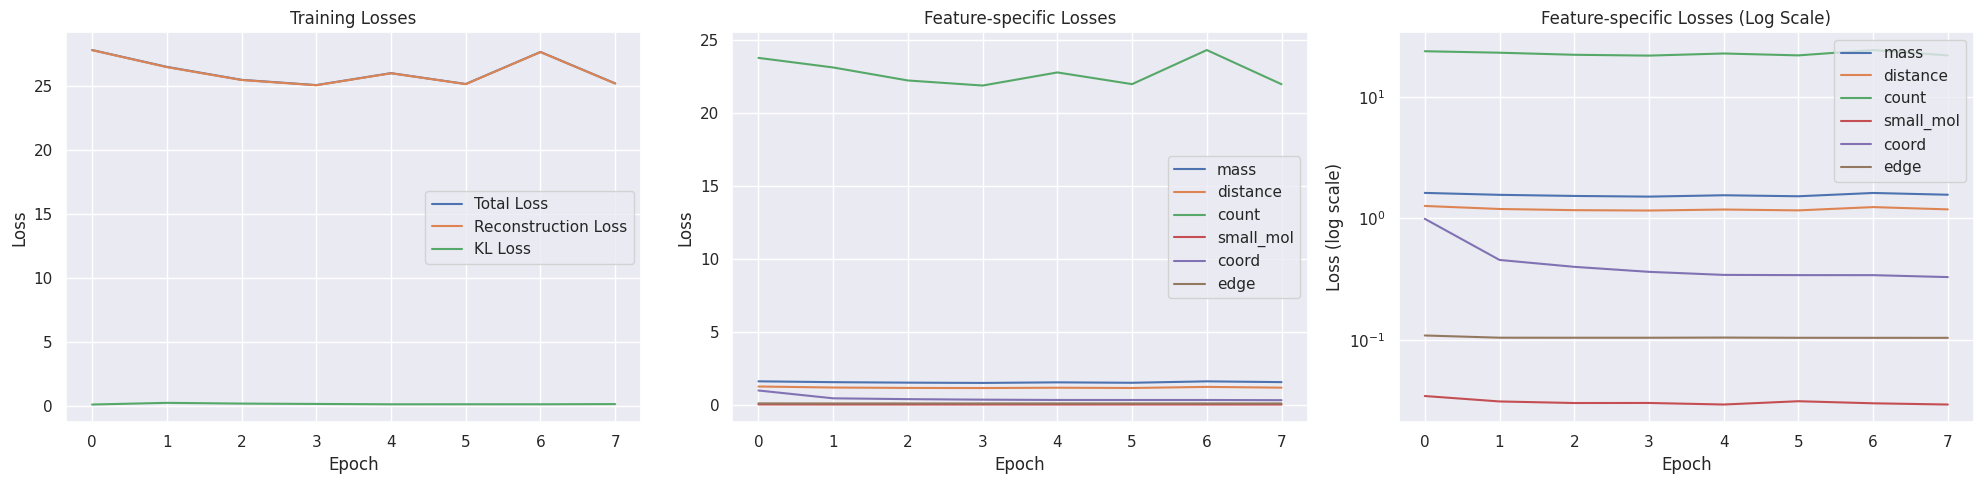

Epoch 9/10 [Train]:   0%|          | 0/83 [00:00<?, ?it/s]


Detailed loss diagnostics:
Raw recon_loss: 20.0550
Raw KL loss: 0.0276
mu mean: -0.0019, std: 0.1663
logvar mean: -0.1776, std: 0.1882
mass: 1.2625
distance: 0.9159
count: 17.4181
small_mol: 0.0346
coord: 0.3226
edge: 0.1013


Epoch 9/10 [Train]:  12%|█▏        | 10/83 [00:27<03:06,  2.56s/it, loss=32.6511, recon=32.6384, kl=0.1268]


Detailed loss diagnostics:
Raw recon_loss: 15.0016
Raw KL loss: 0.0693
mu mean: -0.0056, std: 0.3077
logvar mean: -0.2119, std: 0.2677
mass: 0.8591
distance: 0.6878
count: 13.1093
small_mol: 0.0402
coord: 0.2014
edge: 0.1038


Epoch 9/10 [Train]:  24%|██▍       | 20/83 [00:59<02:40,  2.54s/it, loss=21.2850, recon=21.2803, kl=0.0471]


Detailed loss diagnostics:
Raw recon_loss: 11.1760
Raw KL loss: 0.0557
mu mean: 0.0049, std: 0.2855
logvar mean: -0.1719, std: 0.2111
mass: 0.6900
distance: 0.5492
count: 9.5958
small_mol: 0.0448
coord: 0.1945
edge: 0.1018


Epoch 9/10 [Train]:  36%|███▌      | 30/83 [01:26<02:59,  3.38s/it, loss=43.9603, recon=43.9320, kl=0.2832]


Detailed loss diagnostics:
Raw recon_loss: 46.8474
Raw KL loss: 0.1852
mu mean: -0.0170, std: 0.5372
logvar mean: -0.2689, std: 0.4107
mass: 2.7863
distance: 1.8291
count: 41.6514
small_mol: 0.0282
coord: 0.4505
edge: 0.1018


Epoch 9/10 [Train]:  48%|████▊     | 40/83 [02:00<02:03,  2.88s/it, loss=22.7987, recon=22.7910, kl=0.0762]


Detailed loss diagnostics:
Raw recon_loss: 34.3539
Raw KL loss: 0.0740
mu mean: 0.0053, std: 0.3352
logvar mean: -0.1893, std: 0.2361
mass: 1.9175
distance: 1.4724
count: 30.4638
small_mol: 0.0247
coord: 0.3707
edge: 0.1047


Epoch 9/10 [Train]:  60%|██████    | 50/83 [02:27<01:31,  2.77s/it, loss=21.2867, recon=21.2798, kl=0.0690]


Detailed loss diagnostics:
Raw recon_loss: 29.0655
Raw KL loss: 0.2668
mu mean: -0.0128, std: 0.6617
logvar mean: -0.2570, std: 0.5360
mass: 1.5248
distance: 1.0288
count: 26.2135
small_mol: 0.0285
coord: 0.1672
edge: 0.1027


Epoch 9/10 [Train]:  72%|███████▏  | 60/83 [02:53<01:01,  2.67s/it, loss=21.4449, recon=21.4412, kl=0.0368]


Detailed loss diagnostics:
Raw recon_loss: 9.3634
Raw KL loss: 0.0322
mu mean: 0.0006, std: 0.1971
logvar mean: -0.1713, std: 0.1777
mass: 0.6011
distance: 0.5073
count: 7.8850
small_mol: 0.0384
coord: 0.2291
edge: 0.1025


Epoch 9/10 [Train]:  84%|████████▍ | 70/83 [03:17<00:39,  3.07s/it, loss=42.1858, recon=42.1685, kl=0.1734]


Detailed loss diagnostics:
Raw recon_loss: 15.6684
Raw KL loss: 0.1581
mu mean: -0.0190, std: 0.4983
logvar mean: -0.2494, std: 0.3449
mass: 1.0619
distance: 0.7874
count: 13.5833
small_mol: 0.0196
coord: 0.1151
edge: 0.1010


Epoch 9/10 [Train]:  96%|█████████▋| 80/83 [03:46<00:08,  2.75s/it, loss=35.6311, recon=35.6033, kl=0.2786]


Detailed loss diagnostics:
Raw recon_loss: 25.1990
Raw KL loss: 0.0602
mu mean: 0.0012, std: 0.2965
logvar mean: -0.1846, std: 0.2141
mass: 1.4972
distance: 1.1041
count: 22.1901
small_mol: 0.0264
coord: 0.2791
edge: 0.1020


Epoch 9/10 [Train]: 100%|██████████| 83/83 [03:53<00:00,  2.81s/it, loss=6.2905, recon=6.2873, kl=0.0317]  



Starting validation...


Epoch 9/10 [Valid]: 100%|██████████| 21/21 [00:18<00:00,  1.13it/s]



Epoch [9/10] - Time: 251.98s
Train - Total: 23.2665, Recon: 23.2578, KL: 0.0871
Feature Losses:
  mass_loss: 1.4563
  distance_loss: 1.0993
  count_loss: 20.2428
  small_mol_loss: 0.0319
  coord_loss: 0.3239
  edge_loss: 0.1036


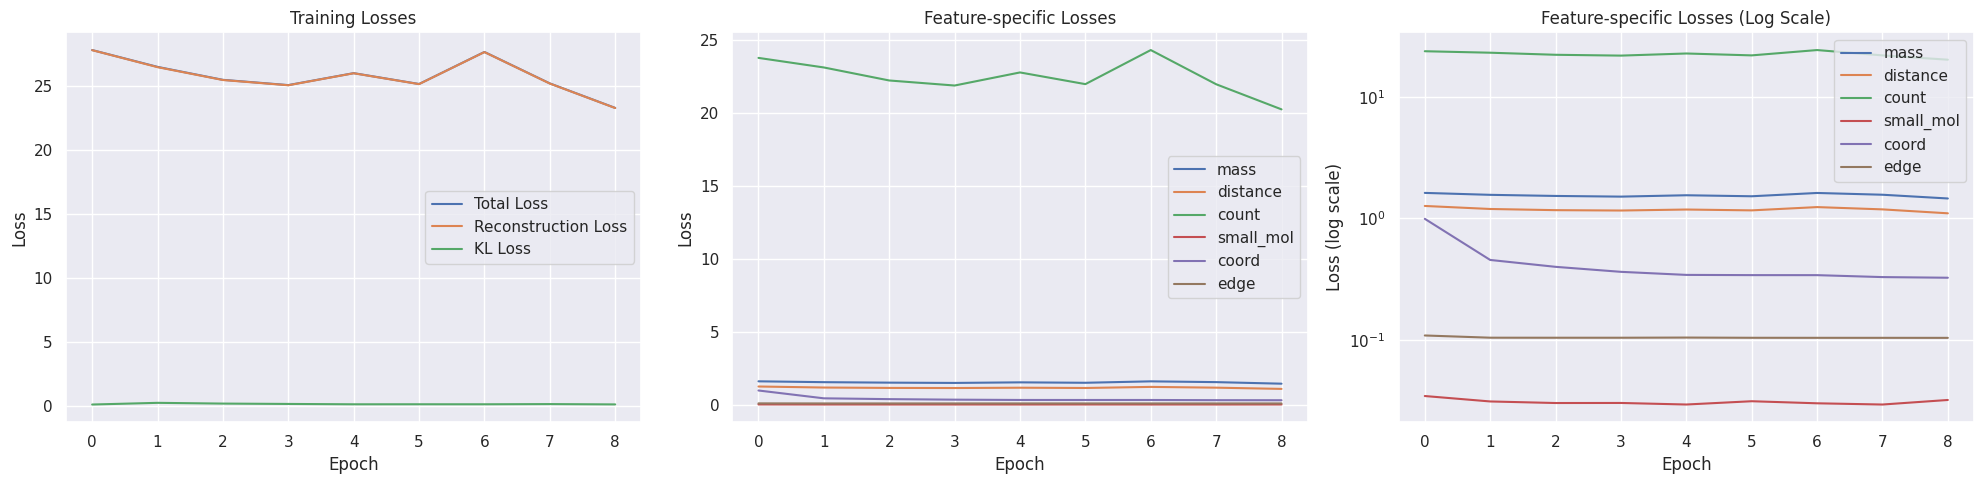

Epoch 10/10 [Train]:   0%|          | 0/83 [00:00<?, ?it/s]


Detailed loss diagnostics:
Raw recon_loss: 16.5537
Raw KL loss: 0.0350
mu mean: 0.0134, std: 0.2176
logvar mean: -0.1399, std: 0.1867
mass: 0.9591
distance: 0.7698
count: 14.4257
small_mol: 0.0330
coord: 0.2621
edge: 0.1041


Epoch 10/10 [Train]:  12%|█▏        | 10/83 [00:27<03:21,  2.76s/it, loss=18.2862, recon=18.2697, kl=0.1655]


Detailed loss diagnostics:
Raw recon_loss: 20.7779
Raw KL loss: 0.1307
mu mean: -0.0004, std: 0.4533
logvar mean: -0.2363, std: 0.3074
mass: 1.2693
distance: 0.9711
count: 18.2492
small_mol: 0.0259
coord: 0.1592
edge: 0.1032


Epoch 10/10 [Train]:  24%|██▍       | 20/83 [00:55<02:44,  2.62s/it, loss=19.0816, recon=19.0751, kl=0.0651]


Detailed loss diagnostics:
Raw recon_loss: 61.0819
Raw KL loss: 0.2060
mu mean: 0.0069, std: 0.5991
logvar mean: -0.1949, std: 0.3442
mass: 3.0366
distance: 2.5366
count: 54.9443
small_mol: 0.0198
coord: 0.4410
edge: 0.1037


Epoch 10/10 [Train]:  36%|███▌      | 30/83 [01:28<02:19,  2.63s/it, loss=11.7935, recon=11.7865, kl=0.0703]


Detailed loss diagnostics:
Raw recon_loss: 2.8295
Raw KL loss: 0.1865
mu mean: -0.0068, std: 0.5481
logvar mean: -0.2609, std: 0.3754
mass: 0.9075
distance: 0.6596
count: 0.9427
small_mol: 0.0192
coord: 0.1879
edge: 0.1126


Epoch 10/10 [Train]:  48%|████▊     | 40/83 [01:53<01:30,  2.10s/it, loss=17.7914, recon=17.7790, kl=0.1243]


Detailed loss diagnostics:
Raw recon_loss: 3.4283
Raw KL loss: 0.2585
mu mean: -0.0154, std: 0.6498
logvar mean: -0.2951, std: 0.4768
mass: 1.1666
distance: 0.8176
count: 1.0903
small_mol: 0.0285
coord: 0.2120
edge: 0.1134


Epoch 10/10 [Train]:  60%|██████    | 50/83 [02:22<01:29,  2.71s/it, loss=14.1577, recon=14.1515, kl=0.0616]


Detailed loss diagnostics:
Raw recon_loss: 18.6983
Raw KL loss: 0.0477
mu mean: 0.0034, std: 0.2459
logvar mean: -0.1885, std: 0.2355
mass: 1.1390
distance: 0.8377
count: 16.2318
small_mol: 0.0275
coord: 0.3619
edge: 0.1003


Epoch 10/10 [Train]:  72%|███████▏  | 60/83 [02:48<00:57,  2.50s/it, loss=30.3347, recon=30.3264, kl=0.0830]


Detailed loss diagnostics:
Raw recon_loss: 25.5929
Raw KL loss: 0.0646
mu mean: 0.0054, std: 0.3047
logvar mean: -0.1838, std: 0.2467
mass: 1.5428
distance: 1.1340
count: 22.4186
small_mol: 0.0314
coord: 0.3638
edge: 0.1022


Epoch 10/10 [Train]:  84%|████████▍ | 70/83 [03:19<00:34,  2.65s/it, loss=11.1457, recon=11.1417, kl=0.0406]


Detailed loss diagnostics:
Raw recon_loss: 19.6584
Raw KL loss: 0.0275
mu mean: 0.0123, std: 0.1826
logvar mean: -0.1369, std: 0.1844
mass: 1.0889
distance: 0.8444
count: 17.2790
small_mol: 0.0331
coord: 0.3104
edge: 0.1026


Epoch 10/10 [Train]:  96%|█████████▋| 80/83 [03:45<00:08,  2.96s/it, loss=53.8372, recon=53.8275, kl=0.0968]


Detailed loss diagnostics:
Raw recon_loss: 3.4237
Raw KL loss: 0.0807
mu mean: 0.0163, std: 0.3682
logvar mean: -0.1279, std: 0.2189
mass: 1.0002
distance: 0.7849
count: 1.2273
small_mol: 0.0172
coord: 0.2837
edge: 0.1104


Epoch 10/10 [Train]: 100%|██████████| 83/83 [03:54<00:00,  2.82s/it, loss=9.4659, recon=9.4463, kl=0.1960]  



Starting validation...


Epoch 10/10 [Valid]: 100%|██████████| 21/21 [00:18<00:00,  1.15it/s]



Epoch [10/10] - Time: 252.38s
Train - Total: 24.2525, Recon: 24.2418, KL: 0.1069
Feature Losses:
  mass_loss: 1.4724
  distance_loss: 1.1271
  count_loss: 21.2167
  small_mol_loss: 0.0296
  coord_loss: 0.2924
  edge_loss: 0.1036


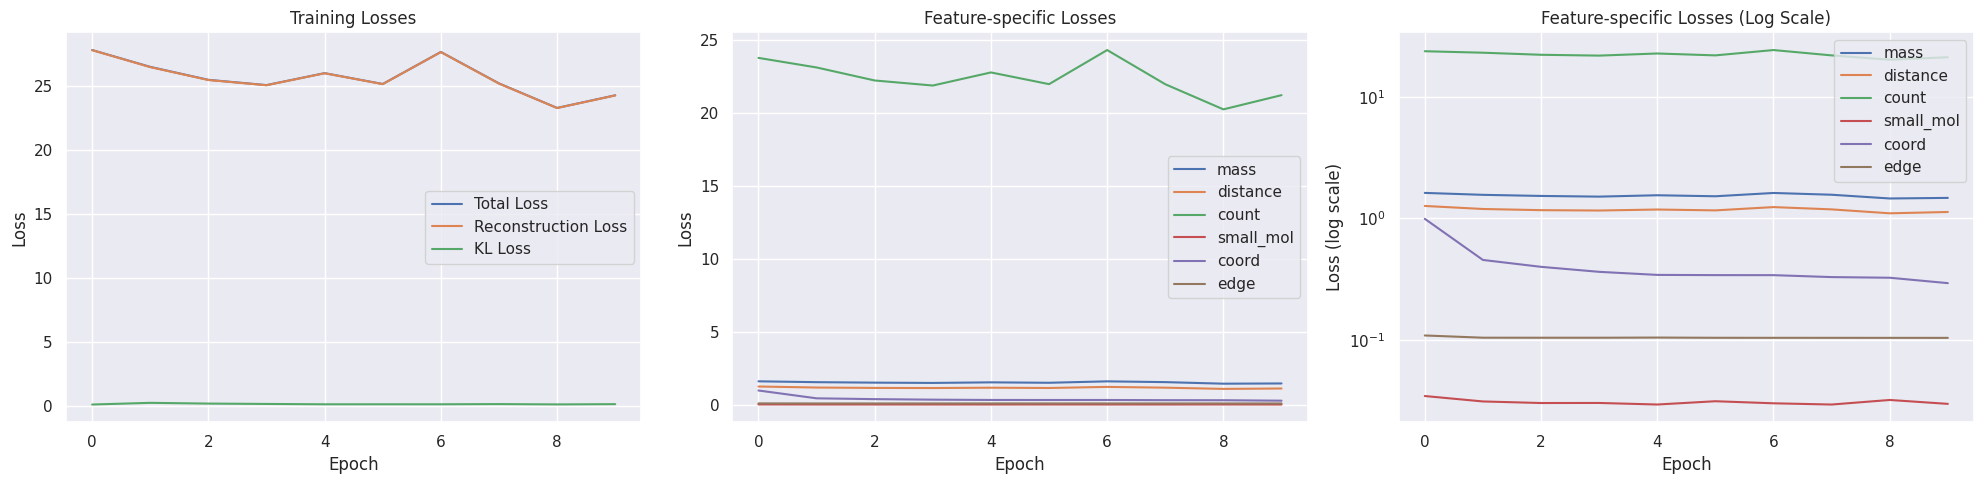


Training completed!


In [27]:
# Adjust batch size for better gradient estimates
train_loader, test_loader, in_channels, norm_params = prepare_graphs_for_vae(
    graphs,
    batch_size=16,  # Increased batch size
    train_ratio=0.8,
    shuffle=True
)

# Update model parameters
model = ProteinGraphVAE(
    in_channels=8,
    hidden_channels=128,  # Increased capacity
    latent_channels=64,
    edge_dim=1
).to(device)



# Adjust learning rate schedule
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Update loss weights in the model to focus on underperforming features
model.loss_weights = {
    'mass': 0.1,
    'distance': 0.1,
    'count': 0.05,     # Lara: Updated, old=0.2 ; Increased to improve count prediction
    'small_mol': 0.1,
    'coord': 0.1,
    'edge': 0.2       # Increased to improve edge reconstruction
}

# Train with slightly different parameters
num_epochs = 10
model, history = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device,
    num_epochs=num_epochs,    # More epochs
    beta=num_epochs / 100      # Lara_updated: old=0.05 ; Slightly increased KL weight
)

# Latent space

In [42]:
def visualize_latent_space(model, data_loader, device='cuda', method='tsne', perplexity=30):
    """
    Visualize the latent space using t-SNE or PCA.

    Parameters:
    - model: Trained ProteinGraphVAE model.
    - data_loader: PyTorch Geometric DataLoader containing graphs.
    - device: 'cuda' or 'cpu'.
    - method: 'tsne' or 'pca' for dimensionality reduction.
    - perplexity: t-SNE perplexity (only for t-SNE).

    Returns:
    - None (displays the plot).
    """
    model.eval()
    model = model.to(device)
    
    latent_vectors = []
    graph_labels = []  # Collect one label per graph

    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            
            # Encode to latent space
            mu, _ = model.encode(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            
            if mu.size(0) == batch.batch.max().item() + 1:
                # mu is already graph-level
                latent_vectors.append(mu.cpu().numpy())
                graph_labels.extend(range(mu.size(0)))
            else:
                # mu is node-level, pool to graph-level
                pooled_mu = global_mean_pool(mu, batch.batch)  # Shape: [num_graphs, latent_dim]
                latent_vectors.append(pooled_mu.cpu().numpy())
                graph_labels.extend(batch.batch.unique().cpu().numpy())  # Graph-level labels
    
    # Concatenate results
    latent_vectors = np.concatenate(latent_vectors, axis=0)
    graph_labels = np.array(graph_labels[:len(latent_vectors)])  # Ensure labels match latent vectors

    # Dimensionality reduction
    if method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    elif method == 'pca':
        reducer = PCA(n_components=2)
    else:
        raise ValueError("Method must be 'tsne' or 'pca'.")
    
    reduced_latent = reducer.fit_transform(latent_vectors)

    # Plotting
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(
        reduced_latent[:, 0],
        reduced_latent[:, 1],
        c=graph_labels[:reduced_latent.shape[0]],  # Use graph-level labels
        cmap='viridis',
        alpha=0.7
    )
    plt.colorbar(scatter, label='Graph Labels')
    plt.title(f'Latent Space Visualization ({method.upper()})')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(True)
    plt.show()



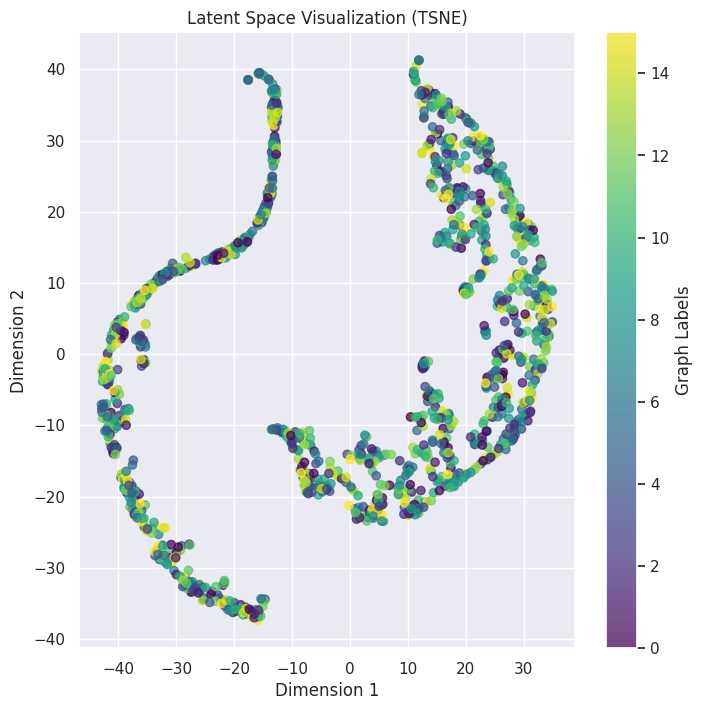

In [43]:
visualize_latent_space(model, train_loader, device=device, method='tsne', perplexity=30)

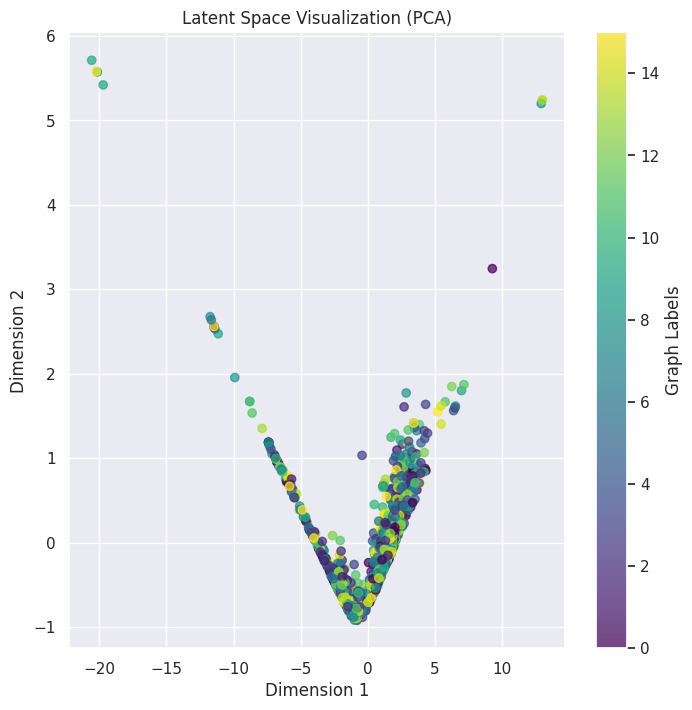

In [44]:
visualize_latent_space(model, train_loader, device=device, method='pca')

# Generator

In [ ]:
import torch
from torch_geometric.data import Data
import numpy as np

def generate_edges_from_coordinates(coords, threshold=5.0):
    """
    Generate edges based on distances between node coordinates.
    """
    edge_index = []
    edge_attr = []

    for i in range(coords.size(0)):
        for j in range(i + 1, coords.size(0)):
            dist = torch.norm(coords[i] - coords[j])
            if dist < threshold:
                edge_index.append([i, j])
                edge_index.append([j, i])
                edge_attr.append([dist.item()])
                edge_attr.append([dist.item()])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    return edge_index, edge_attr



In [ ]:
def generate_protein_graphs(model, graphs, num_samples=5, nodes_per_graph=200, temperature=1.5):
    """
    Generate new protein graphs with diverse node features.
    """
    # Determine device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Step 1: Calculate normalization parameters
    feature_means, feature_stds = norm_params
    print(f"Feature means: {feature_means}")
    print(f"Feature stds: {feature_stds}")

    model.eval()
    model = model.to(device)

    generated_graphs = []

    with torch.no_grad():
        # Step 2: Sample diverse latent vectors
        z = torch.randn(num_samples, model.latent_channels, device=device) * temperature
        print("Sampled latent vectors (z):", z)

        # Step 3: Generate graphs
        for i in range(num_samples):
            # Decode latent vector into node features
            z_expanded = z[i].unsqueeze(0).repeat(nodes_per_graph, 1)
            decoded_features, _ = model.decode(z_expanded, num_nodes=nodes_per_graph, edge_index=torch.empty(2, 0, dtype=torch.long, device=device)) # Placeholder edge_index
            print("Decoded features (before unnormalization):", decoded_features)

            # Unnormalize features
            decoded_features = decoded_features * feature_stds.to(device) + feature_means.to(device)

            # Extract coordinates and generate edges
            coords = decoded_features[:, -3:]  # Last three columns are X, Y, Z
            edge_index, edge_attr = generate_edges_from_coordinates(coords, threshold=5.0)
            print("Edge index:", edge_index)
            print("Edge attributes:", edge_attr)

            # Create PyG Data object
            graph = Data(
                x=decoded_features,
                edge_index=edge_index,
                edge_attr=edge_attr
            )

            generated_graphs.append(graph)

    return generated_graphs


In [135]:
# Extract only the graphs from the tuples
graph_data = [g[1] for g in graphs]

# Use the extracted graphs to generate proteins
generated_proteins = generate_protein_graphs(
    model=model,
    graphs=graph_data,  # Pass only the graphs
    num_samples=5,
    nodes_per_graph=200,
    temperature=1.5
)

Feature means: tensor([-3.5807e-09, -6.4279e-09,  1.1039e-08, -1.1668e-08, -3.3471e-09,
         5.8198e-09,  5.1713e-09, -1.5502e-09])
Feature stds: tensor([1., 1., 1., 1., 1., 1., 1., 1.])
Sampled latent vectors (z): tensor([[-7.0663e-01,  2.1465e+00, -3.3564e-01, -9.2107e-01,  3.5325e+00,
          7.2844e-02,  1.9128e+00,  1.9314e-01, -7.0872e-01,  9.8147e-01,
          5.3765e-01,  4.6414e-01, -1.2849e+00, -9.6652e-01, -7.7628e-01,
         -1.0126e+00,  2.9757e+00,  5.1640e-01, -1.6079e+00, -8.0438e-01,
         -3.1577e+00,  1.4066e+00, -1.7626e+00, -1.0732e+00, -1.5395e+00,
         -5.7910e-01, -2.3557e+00, -1.0246e+00,  1.0714e+00, -2.4492e-01,
          3.4668e-01,  5.6140e-01,  1.0732e+00,  1.2380e-01,  1.0552e+00,
          5.5236e-01,  2.8369e+00,  6.3136e-02,  1.7533e+00, -4.3987e+00,
         -6.4617e-01, -5.9184e-01,  2.0518e+00, -9.0847e-02,  3.2968e-01,
          3.2991e-01,  9.1288e-01, -2.2276e+00,  9.0626e-01, -3.1440e+00,
          9.8829e-01,  4.2749e-01, -3.058

In [110]:
# Analyze the generated graphs
for i, protein in enumerate(generated_proteins):
    print(f"Protein {i+1}:")
    print(f"  Number of nodes: {protein.x.size(0)}")
    print(f"  Number of edges: {protein.edge_index.size(1)}")
    print(f"  Feature mean: {protein.x.mean(dim=0)}")
    print(f"  Feature std: {protein.x.std(dim=0)}")


Protein 1:
  Number of nodes: 200
  Number of edges: 39800
  Feature mean: tensor([[ 0.0001,  0.0001,  0.0001,  ..., -0.0771, -0.1010, -0.0707],
        [ 0.0001,  0.0001,  0.0001,  ..., -0.0772, -0.1010, -0.0708],
        [ 0.0001,  0.0001,  0.0001,  ..., -0.0770, -0.1009, -0.0706],
        ...,
        [ 0.0001,  0.0001,  0.0001,  ..., -0.0778, -0.1015, -0.0710],
        [ 0.0001,  0.0001,  0.0001,  ..., -0.0771, -0.1009, -0.0708],
        [ 0.0001,  0.0001,  0.0001,  ..., -0.0771, -0.1010, -0.0706]])
  Feature std: tensor([[1.0238e-05, 1.0895e-05, 1.2091e-05,  ..., 4.4323e-03, 3.1091e-03,
         2.6492e-03],
        [9.6337e-06, 1.0251e-05, 1.1386e-05,  ..., 4.1997e-03, 2.8779e-03,
         2.4807e-03],
        [1.0455e-05, 1.1139e-05, 1.2360e-05,  ..., 4.6795e-03, 3.3558e-03,
         2.8303e-03],
        ...,
        [9.8658e-06, 1.0511e-05, 1.1676e-05,  ..., 4.1254e-03, 2.8894e-03,
         2.6298e-03],
        [9.5310e-06, 1.0152e-05, 1.1267e-05,  ..., 4.0964e-03, 2.8649e-03,


(test latest version)

In [96]:
import torch
import numpy as np
from torch_geometric.data import Data
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from torch_geometric.data import Data

def generate_protein_graphs(model, norm_params, num_samples=1, nodes_per_graph=100, temperature=1.0):
    """Generate new protein graphs with diverse node features"""
    # Determine device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    feature_means, feature_stds = norm_params  # Unpack normalization parameters
    model.eval()
    model = model.to(device)

    generated_graphs = []

    with torch.no_grad():
        # Sample from normal distribution
        z = torch.randn(num_samples, model.latent_channels, device=device) * temperature

        # Add node-specific variations
        z = z.unsqueeze(1).repeat(1, nodes_per_graph, 1)
        node_noise = torch.randn_like(z) * 0.1
        z = z + node_noise

        # Reshape for decoder
        z = z.view(-1, model.latent_channels)

        # Create initial dummy edge_index for decoding
        edge_index = torch.arange(nodes_per_graph * num_samples, device=device)
        edge_index = edge_index.repeat(2, 1)  # [2, num_nodes]

        # Decode the latent vectors
        decoded, _ = model.decode(z, nodes_per_graph, edge_index)

        # Unnormalize the features
        decoded = decoded * feature_stds.to(device) + feature_means.to(device)


        # Process each generated graph
        for i in range(num_samples):
            # Extract features for this graph
            start_idx = i * nodes_per_graph
            end_idx = (i + 1) * nodes_per_graph
            features = decoded[i]  # Get features for this graph

            # Generate edges based on coordinates
            coords = features[..., -3:]
            edge_index = []
            edge_attr = []

            for j in range(len(coords)):
                for k in range(j + 1, len(coords)):
                    dist = torch.norm(coords[j] - coords[k])
                    if dist < 5.0:  # Threshold for edge creation
                        edge_index.extend([[j, k], [k, j]])
                        edge_attr.extend([dist.item(), dist.item()])

            if len(edge_index) > 0:
                edge_index = torch.tensor(edge_index, dtype=torch.long).t()
                edge_attr = torch.tensor(edge_attr).unsqueeze(1)
            else:
                # Fallback: connect nearest neighbors if no edges were created
                dists = torch.cdist(coords, coords)
                k = 3  # Connect to k nearest neighbors
                _, indices = torch.topk(-dists, k + 1)  # Negative for closest

                edge_index = []
                edge_attr = []
                for j in range(len(coords)):
                    for idx in indices[j][1:]:  # Skip self
                        edge_index.extend([[j, idx.item()], [idx.item(), j]])
                        dist = dists[j, idx].item()
                        edge_attr.extend([dist, dist])

                edge_index = torch.tensor(edge_index, dtype=torch.long).t()
                edge_attr = torch.tensor(edge_attr).unsqueeze(1)

            # Create graph
            graph = Data(
                x=features,
                edge_index=edge_index,
                edge_attr=edge_attr
            )

            generated_graphs.append(graph)

    return generated_graphs


def interpolate_proteins(model, protein1, protein2, num_steps=10, device='cuda'):
    """
    Generate interpolated proteins between two existing proteins
    """
    model.eval()
    model = model.to(device)

    # Convert proteins to batches
    batch1 = torch.zeros(protein1.x.size(0), dtype=torch.long)
    batch2 = torch.zeros(protein2.x.size(0), dtype=torch.long)

    # Get latent representations
    with torch.no_grad():
        protein1 = protein1.to(device)
        protein2 = protein2.to(device)

        mu1, _ = model.encode(protein1.x, protein1.edge_index, protein1.edge_attr, batch1)
        mu2, _ = model.encode(protein2.x, protein2.edge_index, protein2.edge_attr, batch2)

        # Interpolate in latent space
        interpolated_graphs = []
        alphas = np.linspace(0, 1, num_steps)

        max_nodes = max(protein1.x.size(0), protein2.x.size(0))

        for alpha in alphas:
            # Interpolate latent vectors
            z = (1 - alpha) * mu1 + alpha * mu2

            # Create initial dummy edge_index for decoding
            edge_index = torch.arange(max_nodes, device=device)
            edge_index = edge_index.repeat(2, 1)  # [2, num_nodes]

            # Decode
            decoded, _ = model.decode(z.unsqueeze(0), max_nodes, edge_index)
            decoded = decoded[0]

            # Process decoded features
            coords = decoded[:, -3:]

            # Generate edges based on distances
            edge_index = []
            edge_attr = []

            for i in range(len(coords)):
                for j in range(i + 1, len(coords)):
                    dist = torch.norm(coords[i] - coords[j])
                    if dist < 5.0:
                        edge_index.extend([[i, j], [j, i]])
                        edge_attr.extend([dist.item(), dist.item()])

            if len(edge_index) > 0:
                edge_index = torch.tensor(edge_index, dtype=torch.long).t()
                edge_attr = torch.tensor(edge_attr).unsqueeze(1)
            else:
                edge_index = torch.arange(len(coords)).repeat(2, 1)
                edge_attr = torch.ones(len(coords), 1)

            # Create graph
            graph = Data(
                x=decoded,
                edge_index=edge_index,
                edge_attr=edge_attr
            )

            interpolated_graphs.append(graph)

    return interpolated_graphs
def visualize_protein_graph(graph, title="Generated Protein Structure"):
    """Improved visualization of protein graph"""
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Get coordinates
    coords = graph.x[:, -3:].cpu().numpy()
    masses = graph.x[:, 0].cpu().numpy()  # Use mass for point size
    small_mols = graph.x[:, 4].cpu().numpy()  # Use for coloring

    # Scale masses for visualization
    sizes = 50 + (masses - masses.min()) / (masses.max() - masses.min()) * 100

    # Plot nodes with size based on mass and color based on small molecules
    scatter = ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2],
                         c=small_mols, cmap='coolwarm',
                         s=sizes, alpha=0.6)

    # Plot edges
    edges = graph.edge_index.cpu().numpy()
    for i in range(0, edges.shape[1], 2):
        start = coords[edges[0, i]]
        end = coords[edges[1, i]]
        ax.plot([start[0], end[0]],
                [start[1], end[1]],
                [start[2], end[2]], 'gray', alpha=0.2)

    plt.colorbar(scatter, label='Small Molecules')
    ax.set_title(title)

    # Set equal aspect ratio
    ax.set_box_aspect([1,1,1])

    plt.show()


# Example usage:
def generate_and_visualize_proteins(model, device='cuda'):
    """
    Generate and visualize some example proteins
    """
    # Generate new proteins
    print("Generating new proteins...")
    generated = generate_protein_graphs(model, num_samples=3, nodes_per_graph=100, device=device)

    # Visualize each generated protein
    for i, graph in enumerate(generated):
        visualize_protein_graph(graph, f"Generated Protein {i+1}")

    return generated

def interpolate_and_visualize(model, protein1, protein2, device='cuda'):
    """
    Interpolate between two proteins and visualize the results
    """
    print("Generating interpolated proteins...")
    interpolated = interpolate_proteins(model, protein1, protein2, num_steps=5, device=device)

    # Visualize interpolation
    for i, graph in enumerate(interpolated):
        visualize_protein_graph(graph, f"Interpolation Step {i+1}")

    return interpolated

def print_graph_info(graph, title="Graph Info", num_samples=5):
    print(f"\n{title}")
    print(f"Node features shape: {graph.x.shape}")
    print(f"Edge index shape: {graph.edge_index.shape}")

    # Print feature statistics
    print("\nFeature statistics:")
    print(f"Mass range: {graph.x[:, 0].min().item():.2f} to {graph.x[:, 0].max().item():.2f}")
    print(f"Avg Neighbor Dist range: {graph.x[:, 1].min().item():.2f} to {graph.x[:, 1].max().item():.2f}")
    print(f"Max Neighbor Dist range: {graph.x[:, 2].min().item():.2f} to {graph.x[:, 2].max().item():.2f}")
    print(f"Neighbor Count range: {graph.x[:, 3].min().item():.2f} to {graph.x[:, 3].max().item():.2f}")
    print(f"Small Molecules ratio: {graph.x[:, 4].mean().item():.2f}")

    print("\nSample nodes:")
    for i in range(min(num_samples, len(graph.x))):
        features = graph.x[i]
        print(f"\nNode {i}:")
        print(f"  Mass: {features[0].item():.2f}")
        print(f"  Avg/Max Neighbor Dist: {features[1].item():.2f}/{features[2].item():.2f}")
        print(f"  Neighbor Count: {features[3].item():.0f}")
        print(f"  Small Molecules: {features[4].item():.0f}")
        print(f"  Coordinates: ({features[5].item():.2f}, {features[6].item():.2f}, {features[7].item():.2f})")


In [97]:
generated_proteins = generate_protein_graphs(
    model=model,               # The trained model
    norm_params=norm_params,   # Use normalization parameters from preprocessing
    num_samples=3,             # Number of proteins to generate
    nodes_per_graph=100,       # Number of nodes per generated graph
    temperature=1.0            # Sampling diversity
)

In [98]:
def visualize_generated_protein_graph(data, title="Generated Protein Graph"):
    """
    Visualize a generated protein graph with amino acid-specific colors.

    Parameters:
    - data: PyTorch Geometric Data object representing the protein graph.
    - title: Title of the plot.
    """
    # Convert to NetworkX graph
    G = to_networkx(data, edge_attrs=['edge_attr'], node_attrs=['x'])
    for node in G.nodes(data=True):
        print(f"Node data: {node[1]['x']}")
        break

    # Use a layout (try 'spring', 'kamada_kawai', or others)
    pos = nx.spring_layout(G, seed=42)

    # Map nodes to amino acid colors using Avg_Mass (x[0])
    node_colors = [
    map_mass_to_color(float(node[1]['x'][0])) for node in G.nodes(data=True)
    ]

    # Scale node sizes dynamically (e.g., based on Neighbor_Count, x[3])
    node_sizes = [
        max(10, node[1]['x'][3].item() * 50) for node in G.nodes(data=True)
    ]  # Assuming Neighbor_Count is x[3]

    # Scale edge widths dynamically based on edge distances (edge_attr)
    edge_weights = [
        max(0.1, edge[2]['edge_attr'][0].item()) for edge in G.edges(data=True)
    ]

    # Create the figure and axes explicitly
    fig, ax = plt.subplots(figsize=(10, 10))

    # Draw the graph
    nx.draw(
        G,
        pos,
        ax=ax,  # Explicitly set the axes for the graph
        with_labels=False,
        node_color=node_colors,
        node_size=node_sizes,
        edge_color='gray',  # Static edge color for better node visibility
        width=edge_weights,
        alpha=0.9  # Transparency for better visibility
    )

    # Add a legend for amino acid colors
    legend_patches = [
        mpl.patches.Patch(color=color, label=name)
        for _, name, color in AMINO_ACID_DATA
    ]
    ax.legend(handles=legend_patches, loc='upper left', fontsize=8, title="Amino Acids")

    # Add a title
    ax.set_title(title, fontsize=14)
    plt.show()


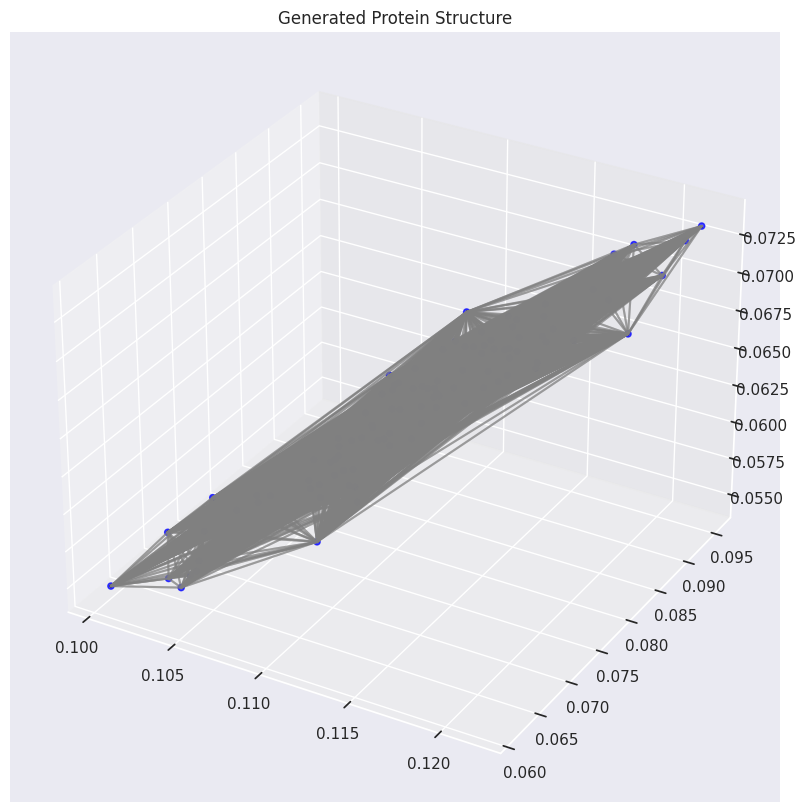

In [99]:
generated_protein = generated_proteins[0]  # Assume you have generated graphs
visualize_protein_structure_from_graph(generated_protein, title="Generated Protein Structure")


In [100]:
generated_proteins[0]

Data(x=[100, 8], edge_index=[2, 9900], edge_attr=[9900, 1])

In [101]:
generated_proteins[1]

Data(x=[100, 8], edge_index=[2, 9900], edge_attr=[9900, 1])

New generator: 

In [102]:
def generate_protein_graphs(model, norm_params, num_samples=3, nodes_per_graph=100, temperature=1.0):
    """Generate new protein graphs with diverse node features"""
    # Determine device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    feature_means, feature_stds = norm_params  # Unpack normalization parameters
    model.eval()
    model = model.to(device)

    generated_graphs = []

    with torch.no_grad():
        # Sample diverse latent vectors
        z = torch.randn(num_samples, model.latent_channels, device=device) * temperature

        # Add small random noise for variability
        z = z + torch.randn_like(z) * 0.1

        for i in range(num_samples):
            # Expand latent vector for all nodes
            z_expanded = z[i].unsqueeze(0).repeat(nodes_per_graph, 1)

            # Decode latent vectors into node features
            decoded_features, _ = model.decode(z_expanded, nodes_per_graph, edge_index=None)

            # Unnormalize features
            decoded_features = decoded_features * feature_stds.to(device) + feature_means.to(device)

            # Generate edges based on spatial coordinates (decoded)
            coords = decoded_features[:, -3:]  # Extract X, Y, Z
            edge_index, edge_attr = generate_edges_from_coordinates(coords, threshold=5.0)

            # Create PyG Data object
            graph = Data(
                x=decoded_features,
                edge_index=edge_index,
                edge_attr=edge_attr
            )

            generated_graphs.append(graph)

    return generated_graphs


def generate_edges_from_coordinates(coords, threshold=5.0):
    """Generate edges based on distances between coordinates"""
    edge_index = []
    edge_attr = []

    for i in range(coords.size(0)):
        for j in range(i + 1, coords.size(0)):
            dist = torch.norm(coords[i] - coords[j])
            if dist < threshold:
                edge_index.append([i, j])
                edge_index.append([j, i])
                edge_attr.append([dist.item()])
                edge_attr.append([dist.item()])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    return edge_index, edge_attr


In [103]:
generated_proteins = generate_protein_graphs(
    model=model,
    norm_params=(feature_means, feature_stds),
    num_samples=3,
    nodes_per_graph=100,
    temperature=1.0
)

# Check if graphs are diverse
for i, graph in enumerate(generated_proteins):
    print(f"Graph {i}: Node Features Mean: {graph.x.mean(dim=0)}, Std: {graph.x.std(dim=0)}")


NameError: name 'feature_means' is not defined